# Installing the package

Install once using the download notebook. Once the repo is public we can use the link to download from github directly.

### Packages 

Import Package

In [1]:
import pyvar as pv

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


## PT 1: Univariate Models

Start with basic VaR models. Start with Vanguard Total World Stock ETF. It's one of the most popular ETFs used as a proxy for global equity markets.

In [3]:
# Download the VT data from YF
vt_data = yf.download("VT", start="2015-01-01", end="2025-01-01")

# Check for missing values in the entire DataFrame (including the new column)
print(vt_data.isnull().sum())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price   Ticker
Close   VT        0
High    VT        0
Low     VT        0
Open    VT        0
Volume  VT        0
dtype: int64


In [4]:
# Compute percentage returns and remove the first NaN
vt_data["Percent Returns"] = vt_data["Close"].pct_change()
vt_returns = vt_data["Percent Returns"].dropna()

In [5]:
vt_returns.head()

Date
2015-01-05   -0.019346
2015-01-06   -0.010034
2015-01-07    0.012885
2015-01-08    0.015095
2015-01-09   -0.006684
Name: Percent Returns, dtype: float64

General setup:

In [6]:
# Set parameters
confidence_level = 0.99 # <----- Can choose 0.95 etc

### Parametric Normal

#### Parametric Normal Expected Shortfall 
For the Normal distribution, the ES has a closed-form solution:

$$
\text{ES}_{\text{normal}} = \sigma \cdot \frac{\phi(z_\alpha)}{1 - \alpha}
$$


Where:  
- $z_\alpha$ is the quantile from the standard Normal distribution  
- $\phi$ is the PDF of the standard Normal  
- $\sigma$ is the standard deviation 


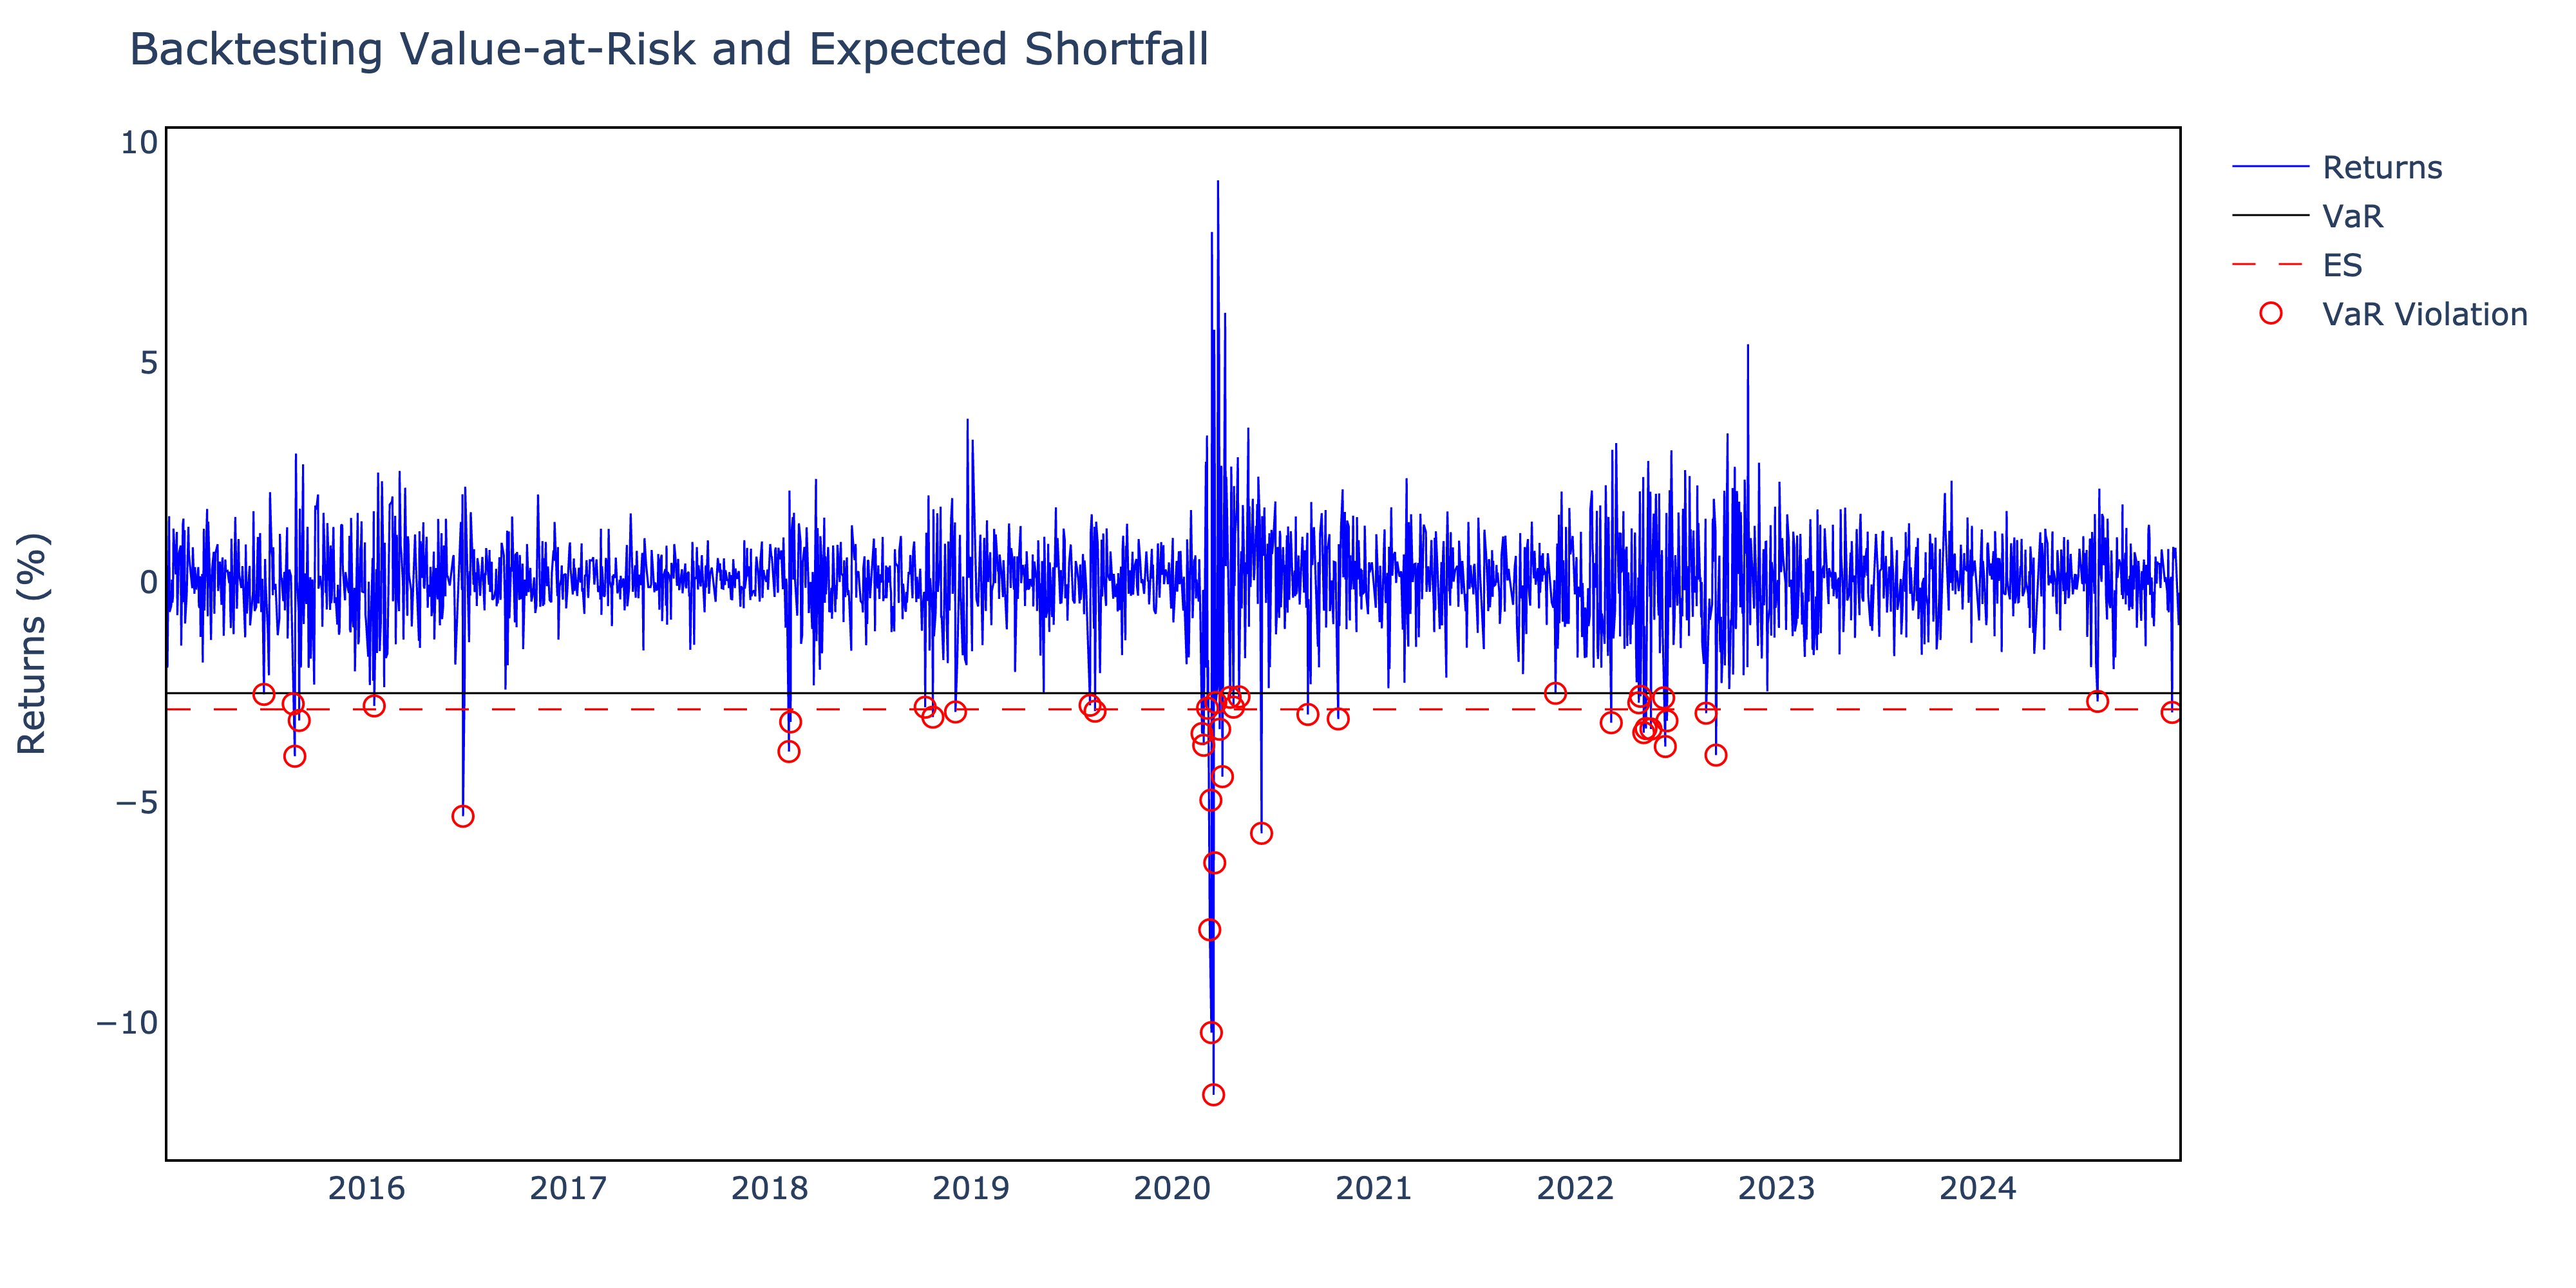

In [7]:
# Apply Parametric VaR model 
parametric_normal_results = pv.parametric_var(vt_returns, confidence_level, distribution="normal")

# Compute ES for the whole period
parametric_normal_results = pv.parametric_es(parametric_normal_results, confidence_level, distribution="normal")

# Plot backtest
plot_parametric_normal = pv.plot_backtest(parametric_normal_results, interactive=False)


In [8]:
parametric_normal_results.head()

Returns       VaR  VaR Violation       ES
Date                                                  
2015-01-05 -0.019346  0.025147          False  0.02881
2015-01-06 -0.010034  0.025147          False  0.02881
2015-01-07  0.012885  0.025147          False  0.02881
2015-01-08  0.015095  0.025147          False  0.02881
2015-01-09 -0.006684  0.025147          False  0.02881

In [9]:
# Count violations
parametric_normal_violations, parametric_normal_violation_rate = pv.count_violations(parametric_normal_results)

# Kupiec Test (Unconditional Coverage)
parametric_normal_kupiec = pv.kupiec_test(
    total_violations=parametric_normal_violations,
    total_days=len(parametric_normal_results),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
parametric_normal_christoffersen = pv.christoffersen_test(parametric_normal_results)

# Joint Test (Conditional Coverage)
parametric_normal_joint = pv.joint_lr_test(
    LR_uc=parametric_normal_kupiec["LR_uc"],
    LR_c=parametric_normal_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- Parametric Normal VaR Backtesting Summary ---")
print(f"Total Violations     : {parametric_normal_violations}")
print(f"Violation Rate       : {parametric_normal_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {parametric_normal_kupiec['LR_uc']:.4f}")
print(f"p-value             : {parametric_normal_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {parametric_normal_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {parametric_normal_christoffersen['LR_c']:.4f}")
print(f"p-value             : {parametric_normal_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {parametric_normal_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {parametric_normal_joint['LR_total']:.4f}")
print(f"p-value             : {parametric_normal_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {parametric_normal_joint['reject_null']}")


--- Parametric Normal VaR Backtesting Summary ---
Total Violations     : 44
Violation Rate       : 1.75%

Kupiec Test (UC):
LR_uc               : 11.6643
p-value             : 0.0006
Reject Null (5%)    : True

Christoffersen Test (Independence):
LR_c                : 3.9355
p-value             : 0.0473
Reject Null (5%)    : True

Joint Test (Conditional Coverage):
LR_total            : 15.5998
p-value             : 0.0004
Reject Null (5%)    : True


### Historical VaR

#### Historical Expected Shortfall (Tail Mean)  
Historical ES is the average of losses that exceed the historical VaR threshold.

$$
\text{ES} = -\mathbb{E}[r_t \mid r_t < -\text{VaR}_\alpha]
$$


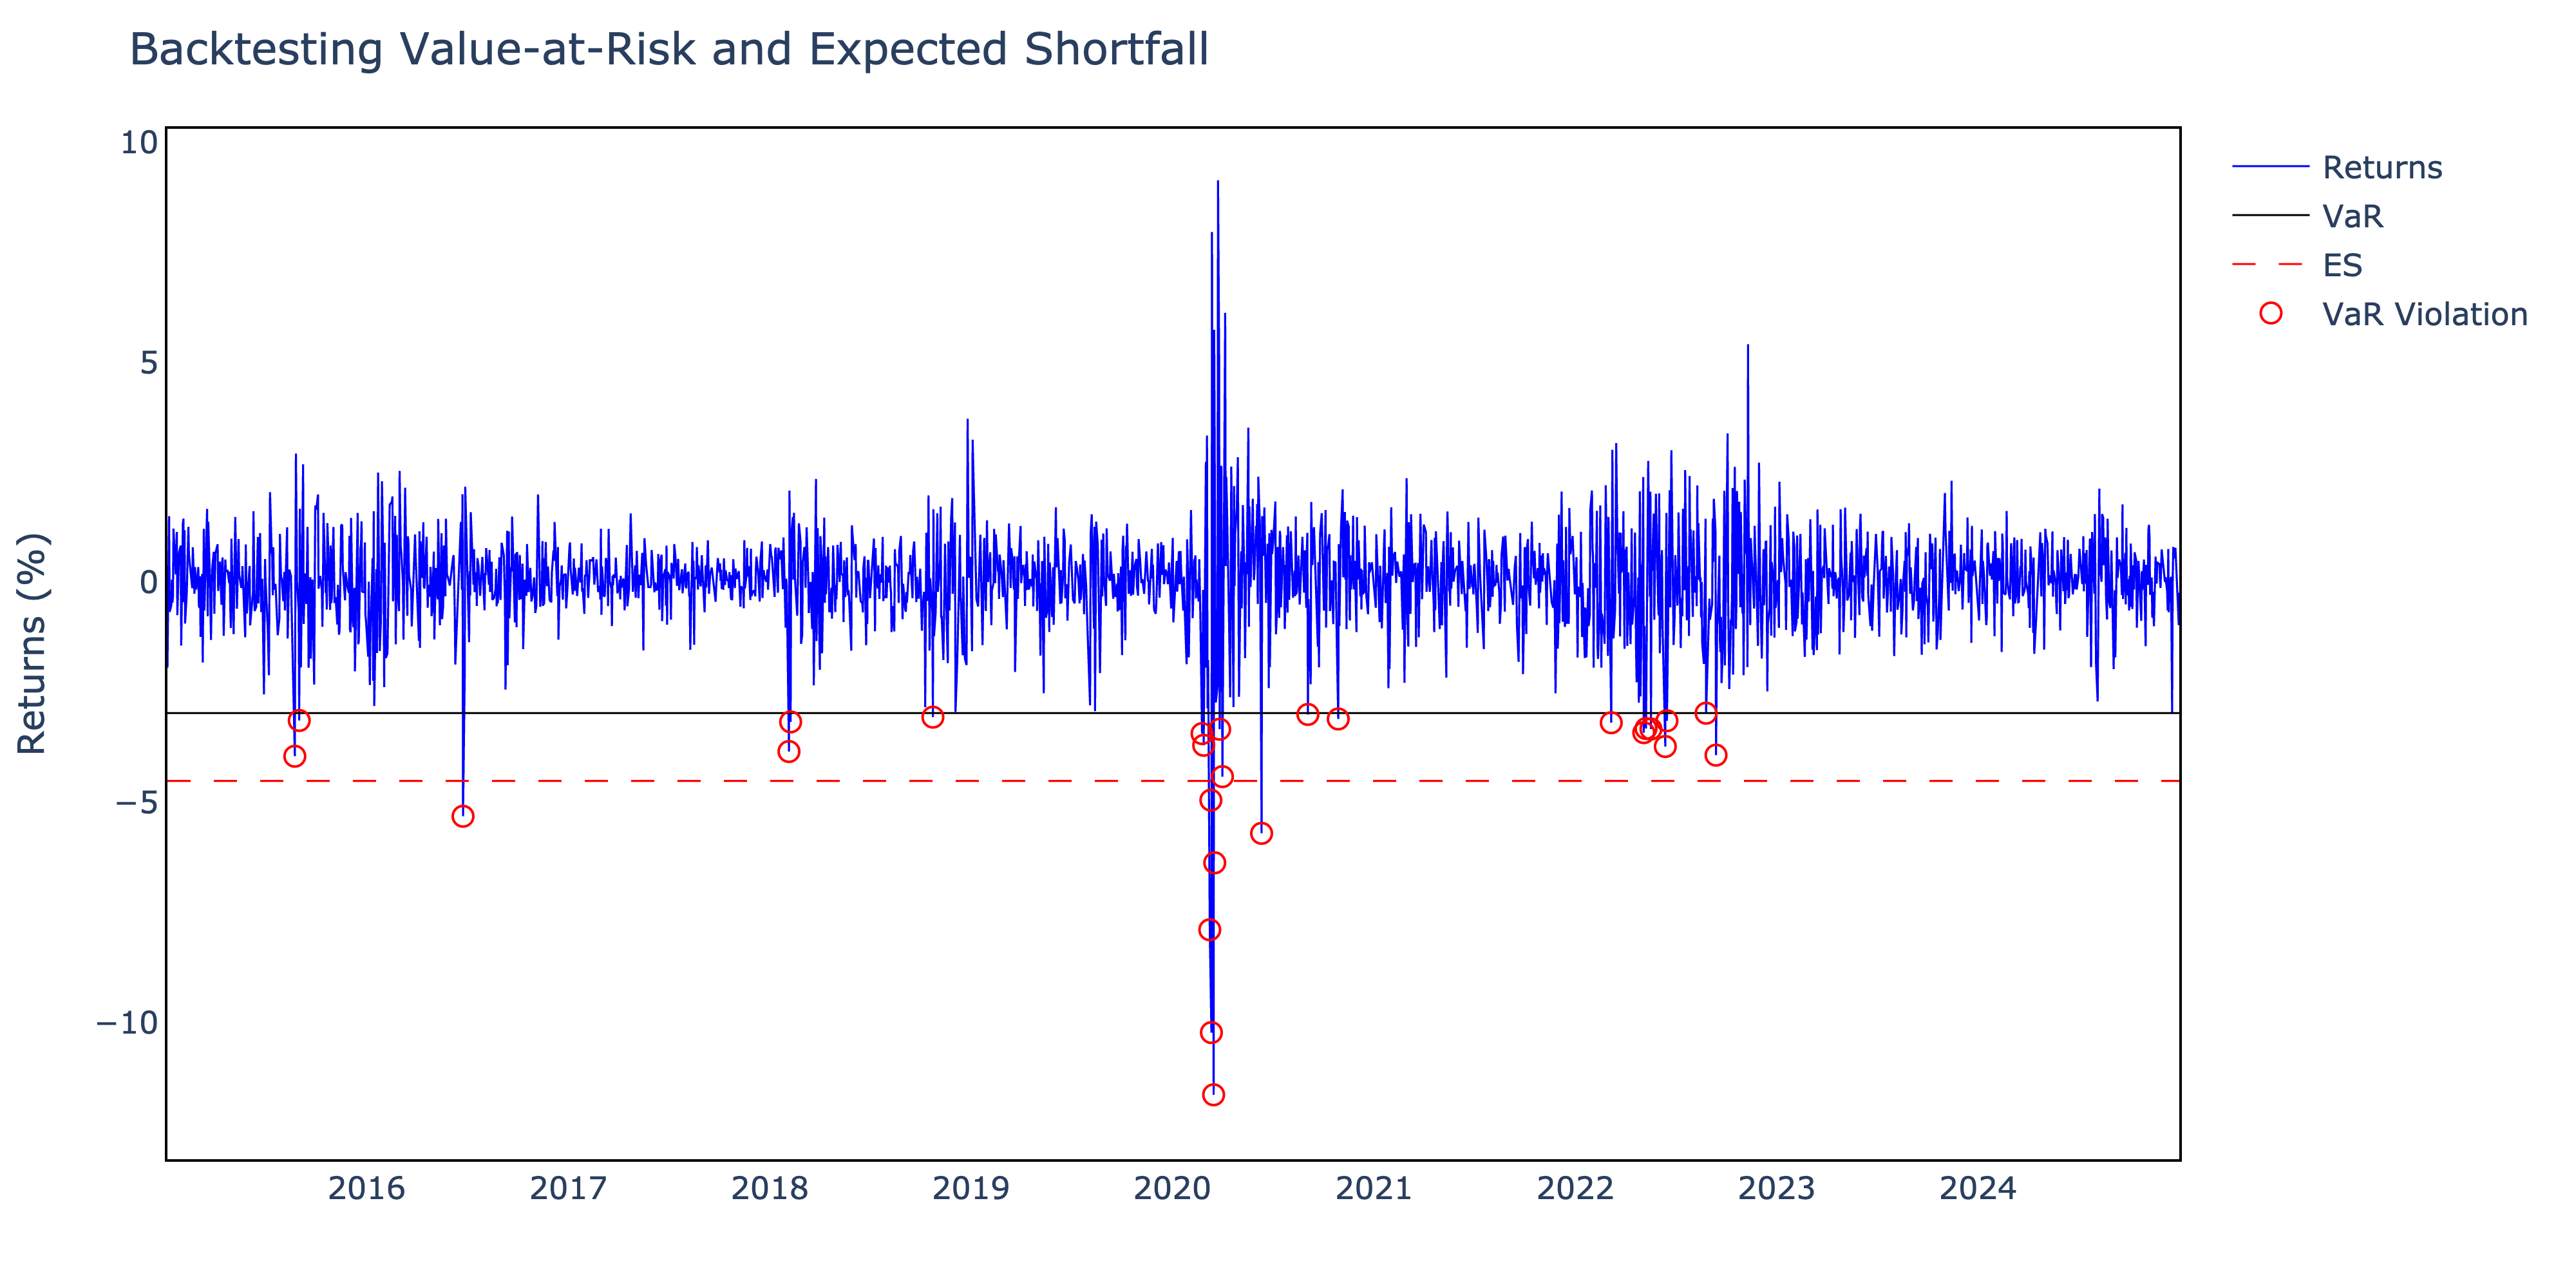

In [10]:
# Apply Parametric VaR model 
historical_results = pv.historical_var(vt_returns, confidence_level)

# Compute ES for the whole period
historical_results = pv.historical_es(historical_results, confidence_level)

# Plot backtest
plot_historical = pv.plot_backtest(historical_results, interactive=False)


In [11]:
historical_results.head()

Returns       VaR  VaR Violation       ES  ES_monetary
Date                                                               
2015-01-05 -0.019346  0.029662          False  0.04508     0.044629
2015-01-06 -0.010034  0.029662          False  0.04508     0.044629
2015-01-07  0.012885  0.029662          False  0.04508     0.044629
2015-01-08  0.015095  0.029662          False  0.04508     0.044629
2015-01-09 -0.006684  0.029662          False  0.04508     0.044629

In [12]:
# Count violations
historical_violations, historical_violation_rate = pv.count_violations(historical_results)

# Kupiec Test (Unconditional Coverage)
historical_kupiec = pv.kupiec_test(
    total_violations=historical_violations,
    total_days=len(historical_results),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
historical_christoffersen = pv.christoffersen_test(historical_results)

# Joint Test (Conditional Coverage)
historical_joint = pv.joint_lr_test(
    LR_uc=historical_kupiec["LR_uc"],
    LR_c=historical_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- Historical Simulation VaR Backtesting Summary ---")
print(f"Total Violations     : {historical_violations}")
print(f"Violation Rate       : {historical_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {historical_kupiec['LR_uc']:.4f}")
print(f"p-value             : {historical_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {historical_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {historical_christoffersen['LR_c']:.4f}")
print(f"p-value             : {historical_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {historical_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {historical_joint['LR_total']:.4f}")
print(f"p-value             : {historical_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {historical_joint['reject_null']}")



--- Historical Simulation VaR Backtesting Summary ---
Total Violations     : 26
Violation Rate       : 1.03%

Kupiec Test (UC):
LR_uc               : 0.0287
p-value             : 0.8655
Reject Null (5%)    : False

Christoffersen Test (Independence):
LR_c                : 1.2068
p-value             : 0.2720
Reject Null (5%)    : False

Joint Test (Conditional Coverage):
LR_total            : 1.2355
p-value             : 0.5391
Reject Null (5%)    : False


### EVT


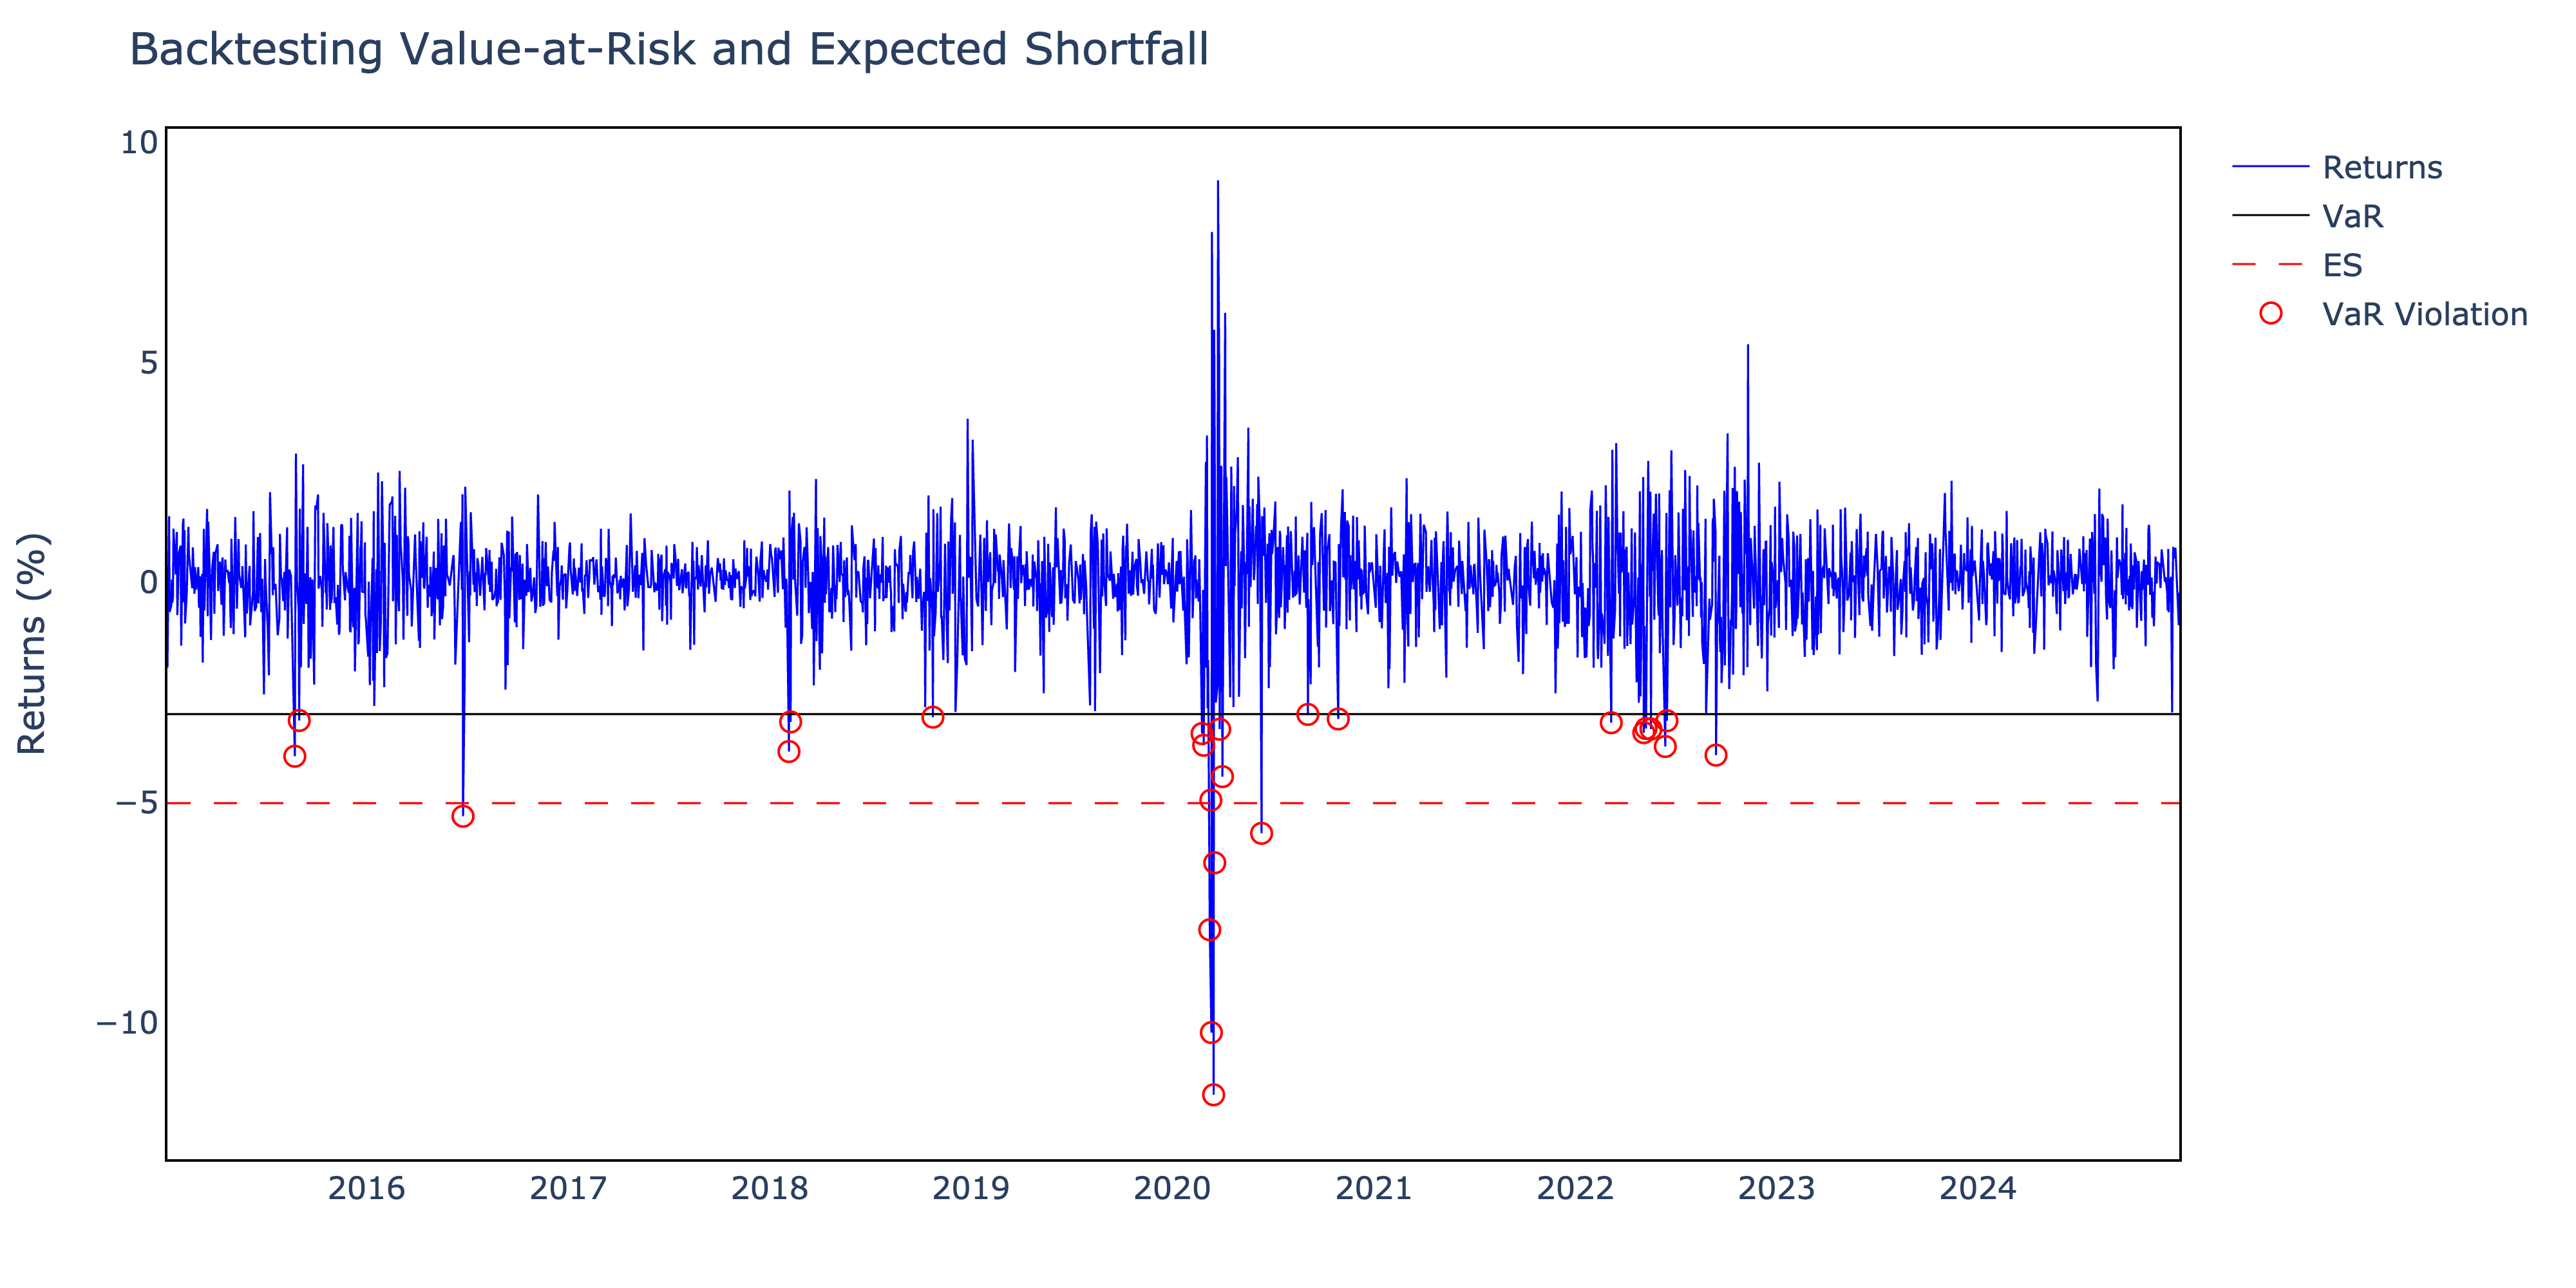

In [13]:
# Apply EVT model
evt_results = pv.evt_var(
    returns=vt_returns,
    confidence_level=confidence_level,
    threshold_percentile=99
    )

# ES
evt_results = pv.evt_es(
    result_data=evt_results,
    threshold_percentile=99
    )

# Plot backtest
plot_evt = pv.plot_backtest(evt_results, interactive=False)

In [14]:
evt_results.head()

Returns       VaR  VaR Violation        ES
Date                                                   
2015-01-05 -0.019346  0.029905          False  0.050131
2015-01-06 -0.010034  0.029905          False  0.050131
2015-01-07  0.012885  0.029905          False  0.050131
2015-01-08  0.015095  0.029905          False  0.050131
2015-01-09 -0.006684  0.029905          False  0.050131

In [15]:
# Count violations
evt_violations, evt_violation_rate = pv.count_violations(evt_results)

# Kupiec Test (Unconditional Coverage)
evt_kupiec = pv.kupiec_test(
    total_violations=evt_violations,
    total_days=len(evt_results),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
evt_christoffersen = pv.christoffersen_test(evt_results)

# Joint Test (Conditional Coverage)
evt_joint = pv.joint_lr_test(
    LR_uc=evt_kupiec["LR_uc"],
    LR_c=evt_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- EVT VaR Backtesting Summary ---")
print(f"Total Violations     : {evt_violations}")
print(f"Violation Rate       : {evt_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {evt_kupiec['LR_uc']:.4f}")
print(f"p-value             : {evt_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {evt_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {evt_christoffersen['LR_c']:.4f}")
print(f"p-value             : {evt_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {evt_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {evt_joint['LR_total']:.4f}")
print(f"p-value             : {evt_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {evt_joint['reject_null']}")



--- EVT VaR Backtesting Summary ---
Total Violations     : 25
Violation Rate       : 0.99%

Kupiec Test (UC):
LR_uc               : 0.0009
p-value             : 0.9760
Reject Null (5%)    : False

Christoffersen Test (Independence):
LR_c                : 1.3273
p-value             : 0.2493
Reject Null (5%)    : False

Joint Test (Conditional Coverage):
LR_total            : 1.3282
p-value             : 0.5147
Reject Null (5%)    : False


### Volatility Modelling

#### GJR-GARCH(p, q) VaR  
GJR-GARCH adds an indicator term to account for the leverage effect of negative shocks.

$$
\sigma_t^2 = \omega + \sum_{i=1}^q \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2 + \sum_{i=1}^q \gamma_i \varepsilon_{t-i}^2 \cdot \mathbb{I}_{\{\varepsilon_{t-i}<0\}}
$$

$$
\text{VaR}_t = -\hat{\sigma}_t \cdot z_\alpha
$$

In [16]:
# Apply GARCH volatility model
garch_results, next_day_var = pv.garch_var(vt_returns, confidence_level, model="GJR", distribution="skewt")

print(f"Next-day GARCH VaR estimate (abs): {100 * next_day_var:.2f}%")

# Compute ES for the whole period
garch_results = pv.volatility_es(garch_results, confidence_level)

Next-day GARCH VaR estimate (abs): 2.98%


In [17]:
# Plot interactive VaR
fig_var = pv.plot_backtest(garch_results, subset=("2015-11-30", "2017-11-30"), interactive = True)

# Plot interactive volatility for a subset
fig_vol = pv.plot_volatility(garch_results["Volatility"], subset=("2015-11-01", "2020-11-30"), interactive=True)

### Forecasting

#### GARCH(1,1) Variance Forecast – Analytical  

Forecast for single-step variance $T$ steps ahead:

$$
\mathbb{E}[\sigma_{t+T}^2] = \text{VL} + (\alpha + \beta)^T \cdot (\sigma_t^2 - \text{VL})
$$

Forecast for cumulative variance over $T$ days:

$$
\mathbb{E}[\sigma_{t,T}^2] =
\text{VL} \cdot \left( T - 1 - \frac{(\alpha + \beta)(1 - (\alpha + \beta)^{T - 1})}{1 - (\alpha + \beta)} \right)
+ \sigma_t^2 \cdot \frac{1 - (\alpha + \beta)^T}{1 - (\alpha + \beta)}
$$

Where:

- $\text{VL} = \dfrac{\omega}{1 - \alpha - \beta}$ is the long-run variance  
- $\sigma_t^2$ is the last fitted conditional variance  


#### GARCH(1,1) VaR Forecast – Analytical  

Once variance is forecasted, the VaR over the horizon $T$ is:

$$
\text{VaR}_{t,T} = - z_\alpha \cdot \sqrt{\mathbb{E}[\sigma_{t,T}^2]}
$$

Where $z_\alpha$ is the quantile of the fitted standardized innovation distribution.


In [18]:
steps_list = [3, 10, 20]
cumulative_list = [False, True]

print("\n--- GARCH(1,1) VaR Forecasts (99% Confidence) ---")
for steps, is_cumulative in product(steps_list, cumulative_list):
    try:
        var_estimate = pv.forecast_garch_var(
            returns=vt_returns,
            steps_ahead=steps,
            cumulative=is_cumulative,
            confidence_level=0.99
        )
        tag = "CUM" if is_cumulative else "Single"
        print(f"VaR | {steps}-day | {tag:<6}: {var_estimate * 100:.4f}%")
    except Exception as e:
        print(f"VaR | {steps}-day | {tag:<6}: ERROR → {e}")

print("\n--- GARCH(1,1) Volatility Forecasts ---")
for steps, is_cumulative in product(steps_list, cumulative_list):
    try:
        variance = pv.forecast_garch_variance(
            returns=vt_returns,
            steps_ahead=steps,
            cumulative=is_cumulative
        )
        vol_pct = np.sqrt(variance) * 100
        tag = "CUM" if is_cumulative else "Single"
        print(f"Volatility | {steps}-day | {tag:<6}: {vol_pct:.4f}%")
    except Exception as e:
        print(f"Volatility | {steps}-day | {tag:<6}: ERROR → {e}")



--- GARCH(1,1) VaR Forecasts (99% Confidence) ---
VaR | 3-day | Single: 2.8049%
VaR | 3-day | CUM   : 4.8150%
VaR | 10-day | Single: 2.8799%
VaR | 10-day | CUM   : 8.9210%
VaR | 20-day | Single: 2.9620%
VaR | 20-day | CUM   : 12.8372%

--- GARCH(1,1) Volatility Forecasts ---
Volatility | 3-day | Single: 0.9676%
Volatility | 3-day | CUM   : 1.6610%
Volatility | 10-day | Single: 0.9935%
Volatility | 10-day | CUM   : 3.0774%
Volatility | 20-day | Single: 1.0218%
Volatility | 20-day | CUM   : 4.4283%


In [19]:
# Count violations
garch_violations, garch_violation_rate = pv.count_violations(garch_results)

# Kupiec Test (Unconditional Coverage)
garch_kupiec = pv.kupiec_test(
    total_violations=garch_violations,
    total_days=len(garch_results),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
garch_christoffersen = pv.christoffersen_test(garch_results)

# Joint Test (Conditional Coverage)
garch_joint = pv.joint_lr_test(
    LR_uc=garch_kupiec["LR_uc"],
    LR_c=garch_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- GARCH VaR Backtesting Summary (GJR, skewed-t) ---")
print(f"Total Violations     : {garch_violations}")
print(f"Violation Rate       : {garch_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {garch_kupiec['LR_uc']:.4f}")
print(f"p-value             : {garch_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {garch_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {garch_christoffersen['LR_c']:.4f}")
print(f"p-value             : {garch_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {garch_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {garch_joint['LR_total']:.4f}")
print(f"p-value             : {garch_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {garch_joint['reject_null']}")



--- GARCH VaR Backtesting Summary (GJR, skewed-t) ---
Total Violations     : 26
Violation Rate       : 1.03%

Kupiec Test (UC):
LR_uc               : 0.0287
p-value             : 0.8655
Reject Null (5%)    : False

Christoffersen Test (Independence):
LR_c                : 1.2068
p-value             : 0.2720
Reject Null (5%)    : False

Joint Test (Conditional Coverage):
LR_total            : 1.2355
p-value             : 0.5391
Reject Null (5%)    : False


## PT 2: Portfolio Models

Highly diversified global equity strategy: long global, regional, and sector ETFs (VT, VGK, EWJ, VWO, SPY) and stable leaders in tech, healthcare, and consumer sectors (AAPL, JNJ, PG, UNH, NVS); small short in industrials (XLI) as a cyclical hedge. Portfolio valued in CHF.

In [20]:
# Define shares — globally diversified portfolio
shares = pd.Series({
    "VT": 120,     # Global equity ETF
    "SPY": 80,     # US large-cap ETF
    "VGK": 60,     # Europe ETF
    "EWJ": 40,     # Japan ETF
    "VWO": 60,     # Emerging Markets ETF
    "AAPL": 50,    # Apple — tech
    "JNJ": 50,     # Johnson & Johnson — healthcare
    "PG": 40,      # Procter & Gamble — consumer staples
    "UNH": 40,     # UnitedHealth — healthcare
    "NVS": 30,     # Novartis — Swiss healthcare
    "XLI": -30     # US industrials sector ETF — short hedge
})

# Download prices and convert to base currency
tickers = shares.index.tolist()
raw_prices = pv.get_raw_prices(tickers, start="2020-01-01", end="2025-01-01")
prices_chf = pv.convert_to_base(raw_prices, base_currency="CHF")

# Compute monetary position values over time
portfolio_matrix = pv.create_portfolio(prices_chf, shares)

# Compute portfolio returns and statistics
portfolio_returns, average_returns, vcv_matrix = pv.summary_statistics(portfolio_matrix)

# Compute latest portfolio value and weights
latest_prices = prices_chf.iloc[-1]
portfolio_value_chf = (shares * latest_prices).sum()
weights = (shares * latest_prices) / portfolio_value_chf

[currency detection] AAPL: USD
[currency detection] EWJ: USD
[currency detection] JNJ: USD
[currency detection] NVS: USD
[currency detection] PG: USD
[currency detection] SPY: USD
[currency detection] UNH: USD
[currency detection] VGK: USD
[currency detection] VT: USD
[currency detection] VWO: USD
[currency detection] XLI: USD
[fx download] Downloading FX pairs: CHFUSD=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] EWJ: USD → CHF via CHFUSD=X
[conversion] JNJ: USD → CHF via CHFUSD=X
[conversion] NVS: USD → CHF via CHFUSD=X
[conversion] PG: USD → CHF via CHFUSD=X
[conversion] SPY: USD → CHF via CHFUSD=X
[conversion] UNH: USD → CHF via CHFUSD=X
[conversion] VGK: USD → CHF via CHFUSD=X
[conversion] VT: USD → CHF via CHFUSD=X
[conversion] VWO: USD → CHF via CHFUSD=X
[conversion] XLI: USD → CHF via CHFUSD=X


In [21]:
# Print final portfolio value and weights
print(f"\nFinal portfolio value in CHF: {portfolio_value_chf:,.2f}\n")
print("Portfolio weights (based on latest prices):")
print(weights.round(4).sort_values(ascending=False))


Final portfolio value in CHF: 104,075.56

Portfolio weights (based on latest prices):
SPY     0.4057
UNH     0.1749
VT      0.1220
AAPL    0.1084
JNJ     0.0623
PG      0.0575
VGK     0.0329
NVS     0.0244
EWJ     0.0233
VWO     0.0229
XLI    -0.0342
dtype: float64



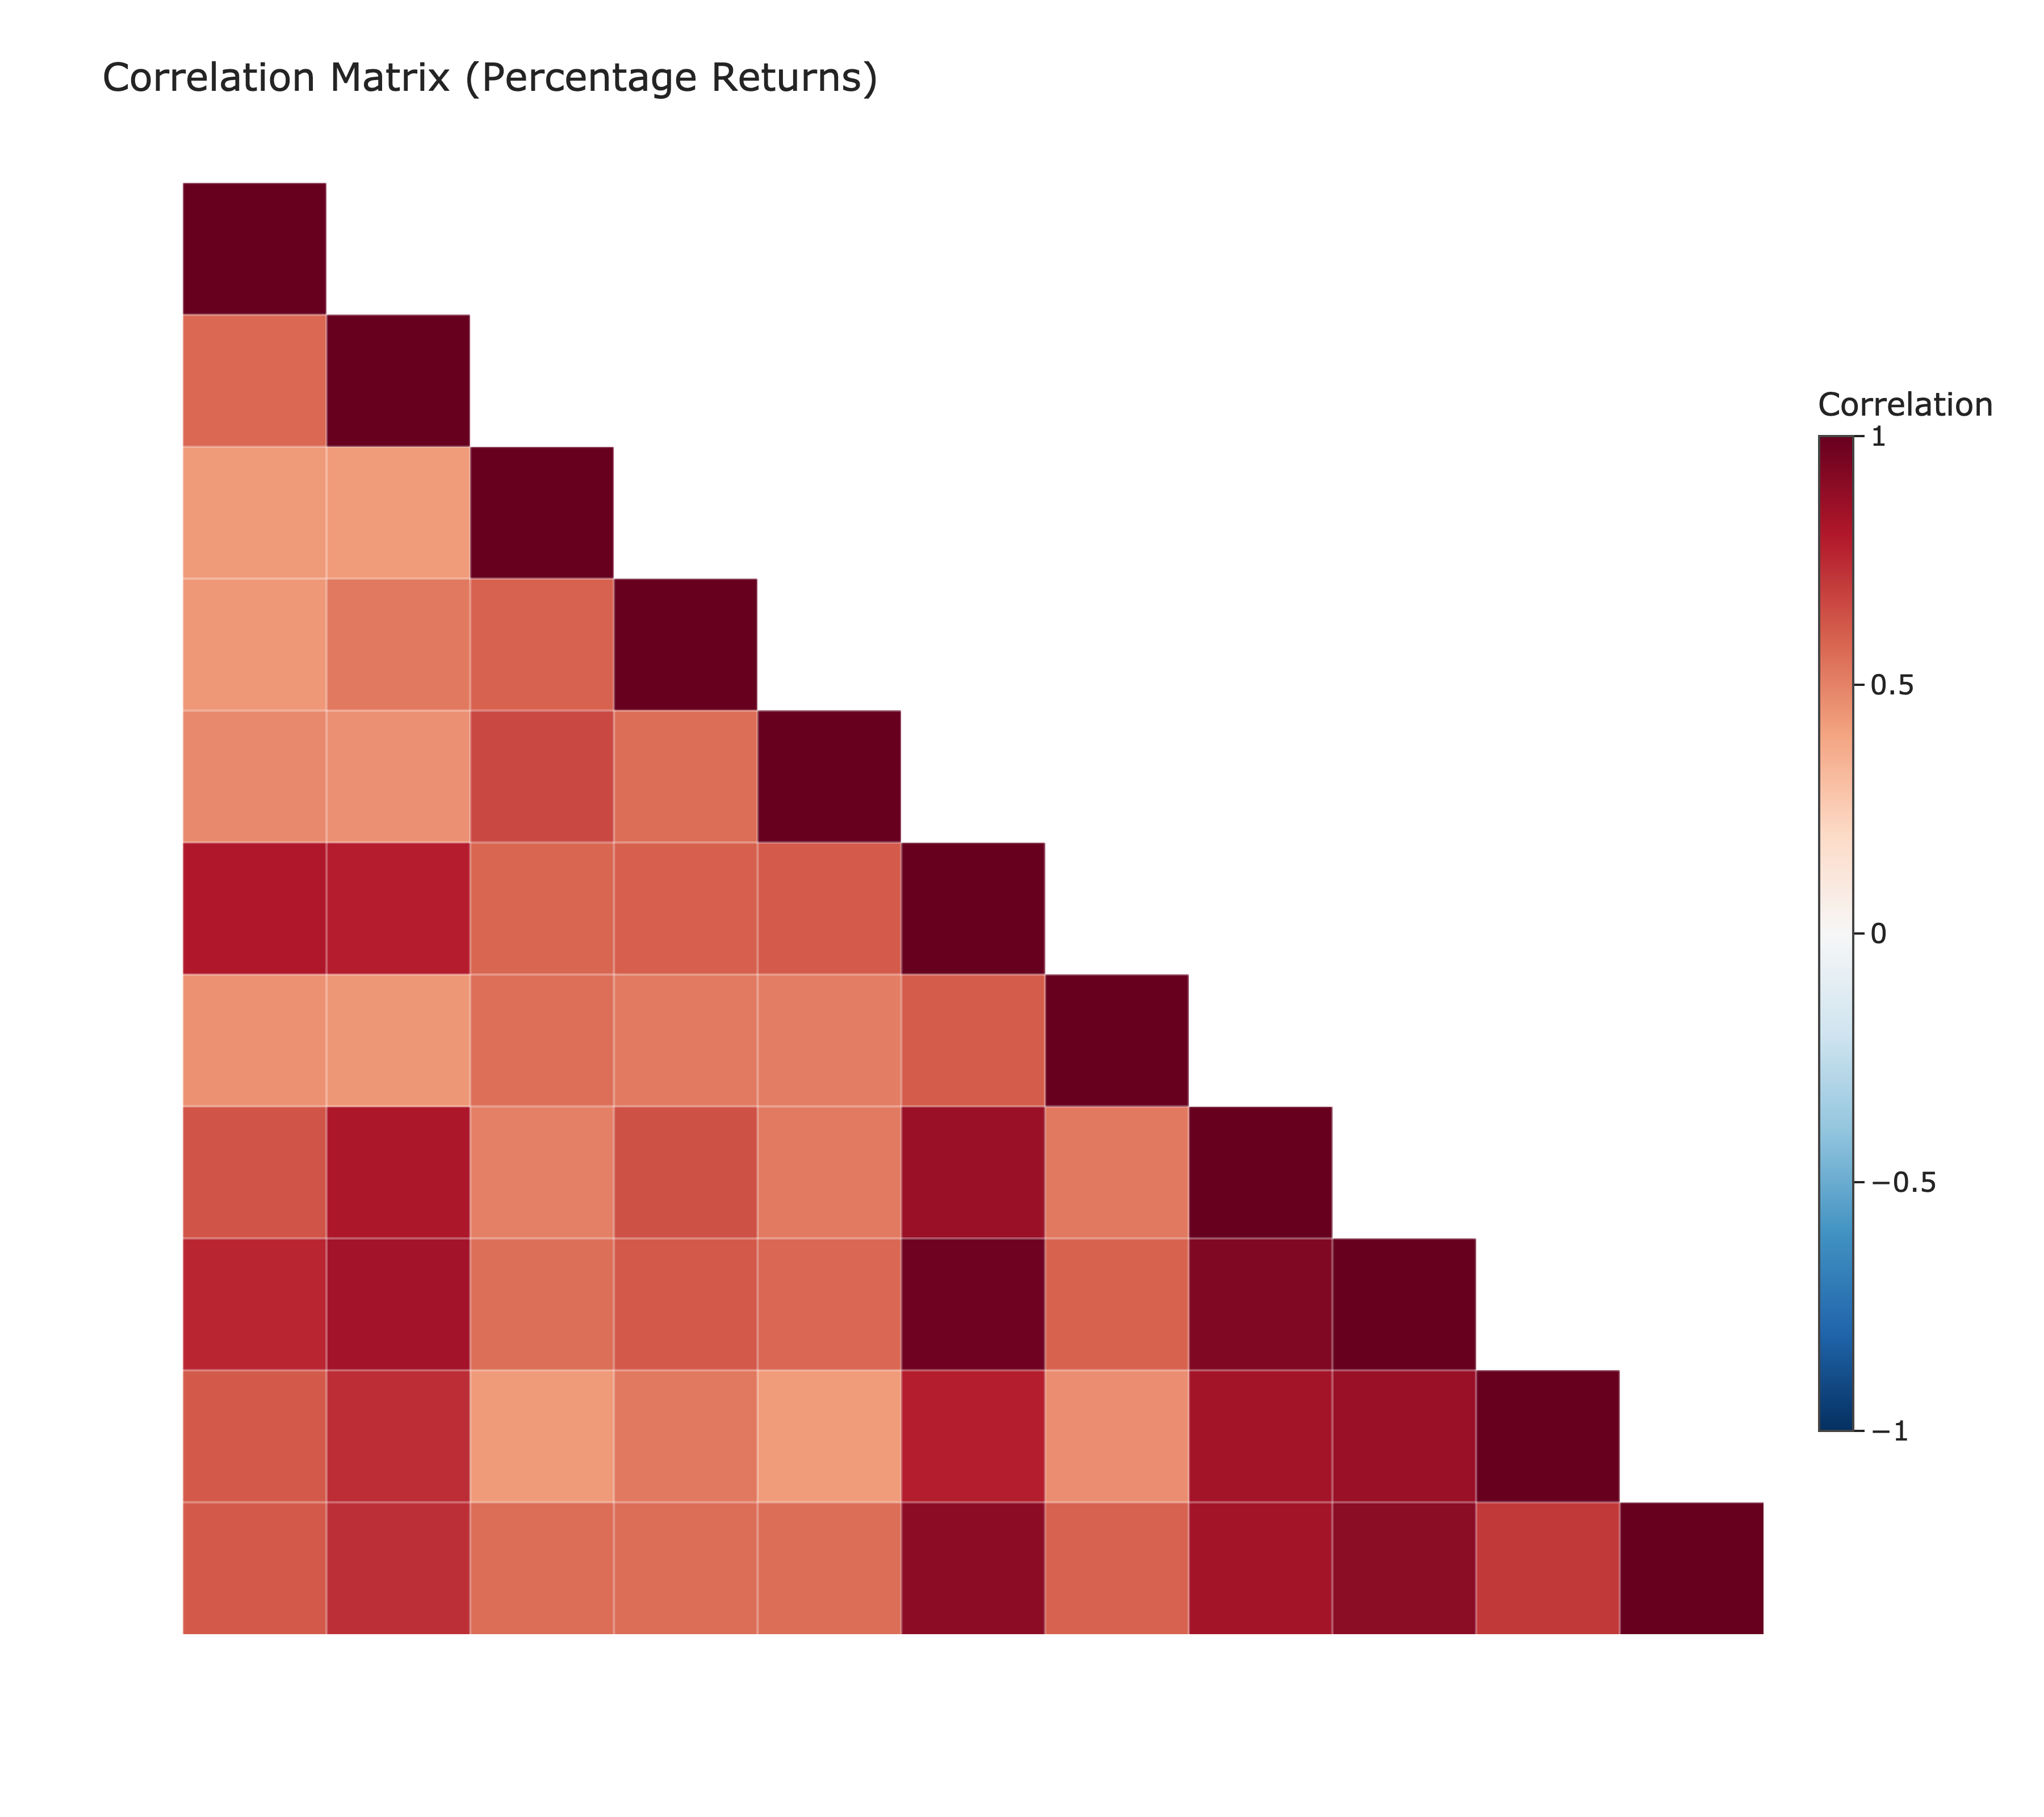

In [22]:
pv.plot_correlation_matrix(portfolio_matrix, interactive=False)

### Portfolio Metrics

- **Asset-Normal VaR (AN VaR)**  
  $$
  \text{VaR}_t = z_\alpha \cdot \sqrt{x_t^\top \Sigma x_t} \cdot \sqrt{h}
  $$

- **Undiversified VaR (UVaR)**  
  $$
  \text{UVaR}_t = z_\alpha \cdot \sum_{i=1}^N \sigma_i x_{i,t} \cdot \sqrt{h}
  $$


In [ ]:
# Compute and display the AN VaR   
asset_normal_results = pv.asset_normal_var(position_data=portfolio_matrix,
                                 confidence_level=confidence_level)

In [24]:
asset_normal_results.head(-4)

Diversified_VaR  Undiversified_VaR  Diversification_Benefit
Date                                                                   
2020-01-03      1891.846477        2232.634092               340.787615
2020-01-06      1900.404279        2242.696500               342.292221
2020-01-07      1888.370476        2228.504617               340.134141
2020-01-08      1904.394565        2247.940871               343.546307
2020-01-09      1922.096331        2268.467766               346.371435
...                     ...                ...                      ...
2024-12-18      3190.150439        3731.044461               540.894022
2024-12-19      3212.031806        3754.720672               542.688866
2024-12-20      3242.119528        3789.782977               547.663449
2024-12-23      3242.395522        3790.489473               548.093951
2024-12-24      3286.275871        3839.976653               553.700781

[1253 rows x 3 columns]


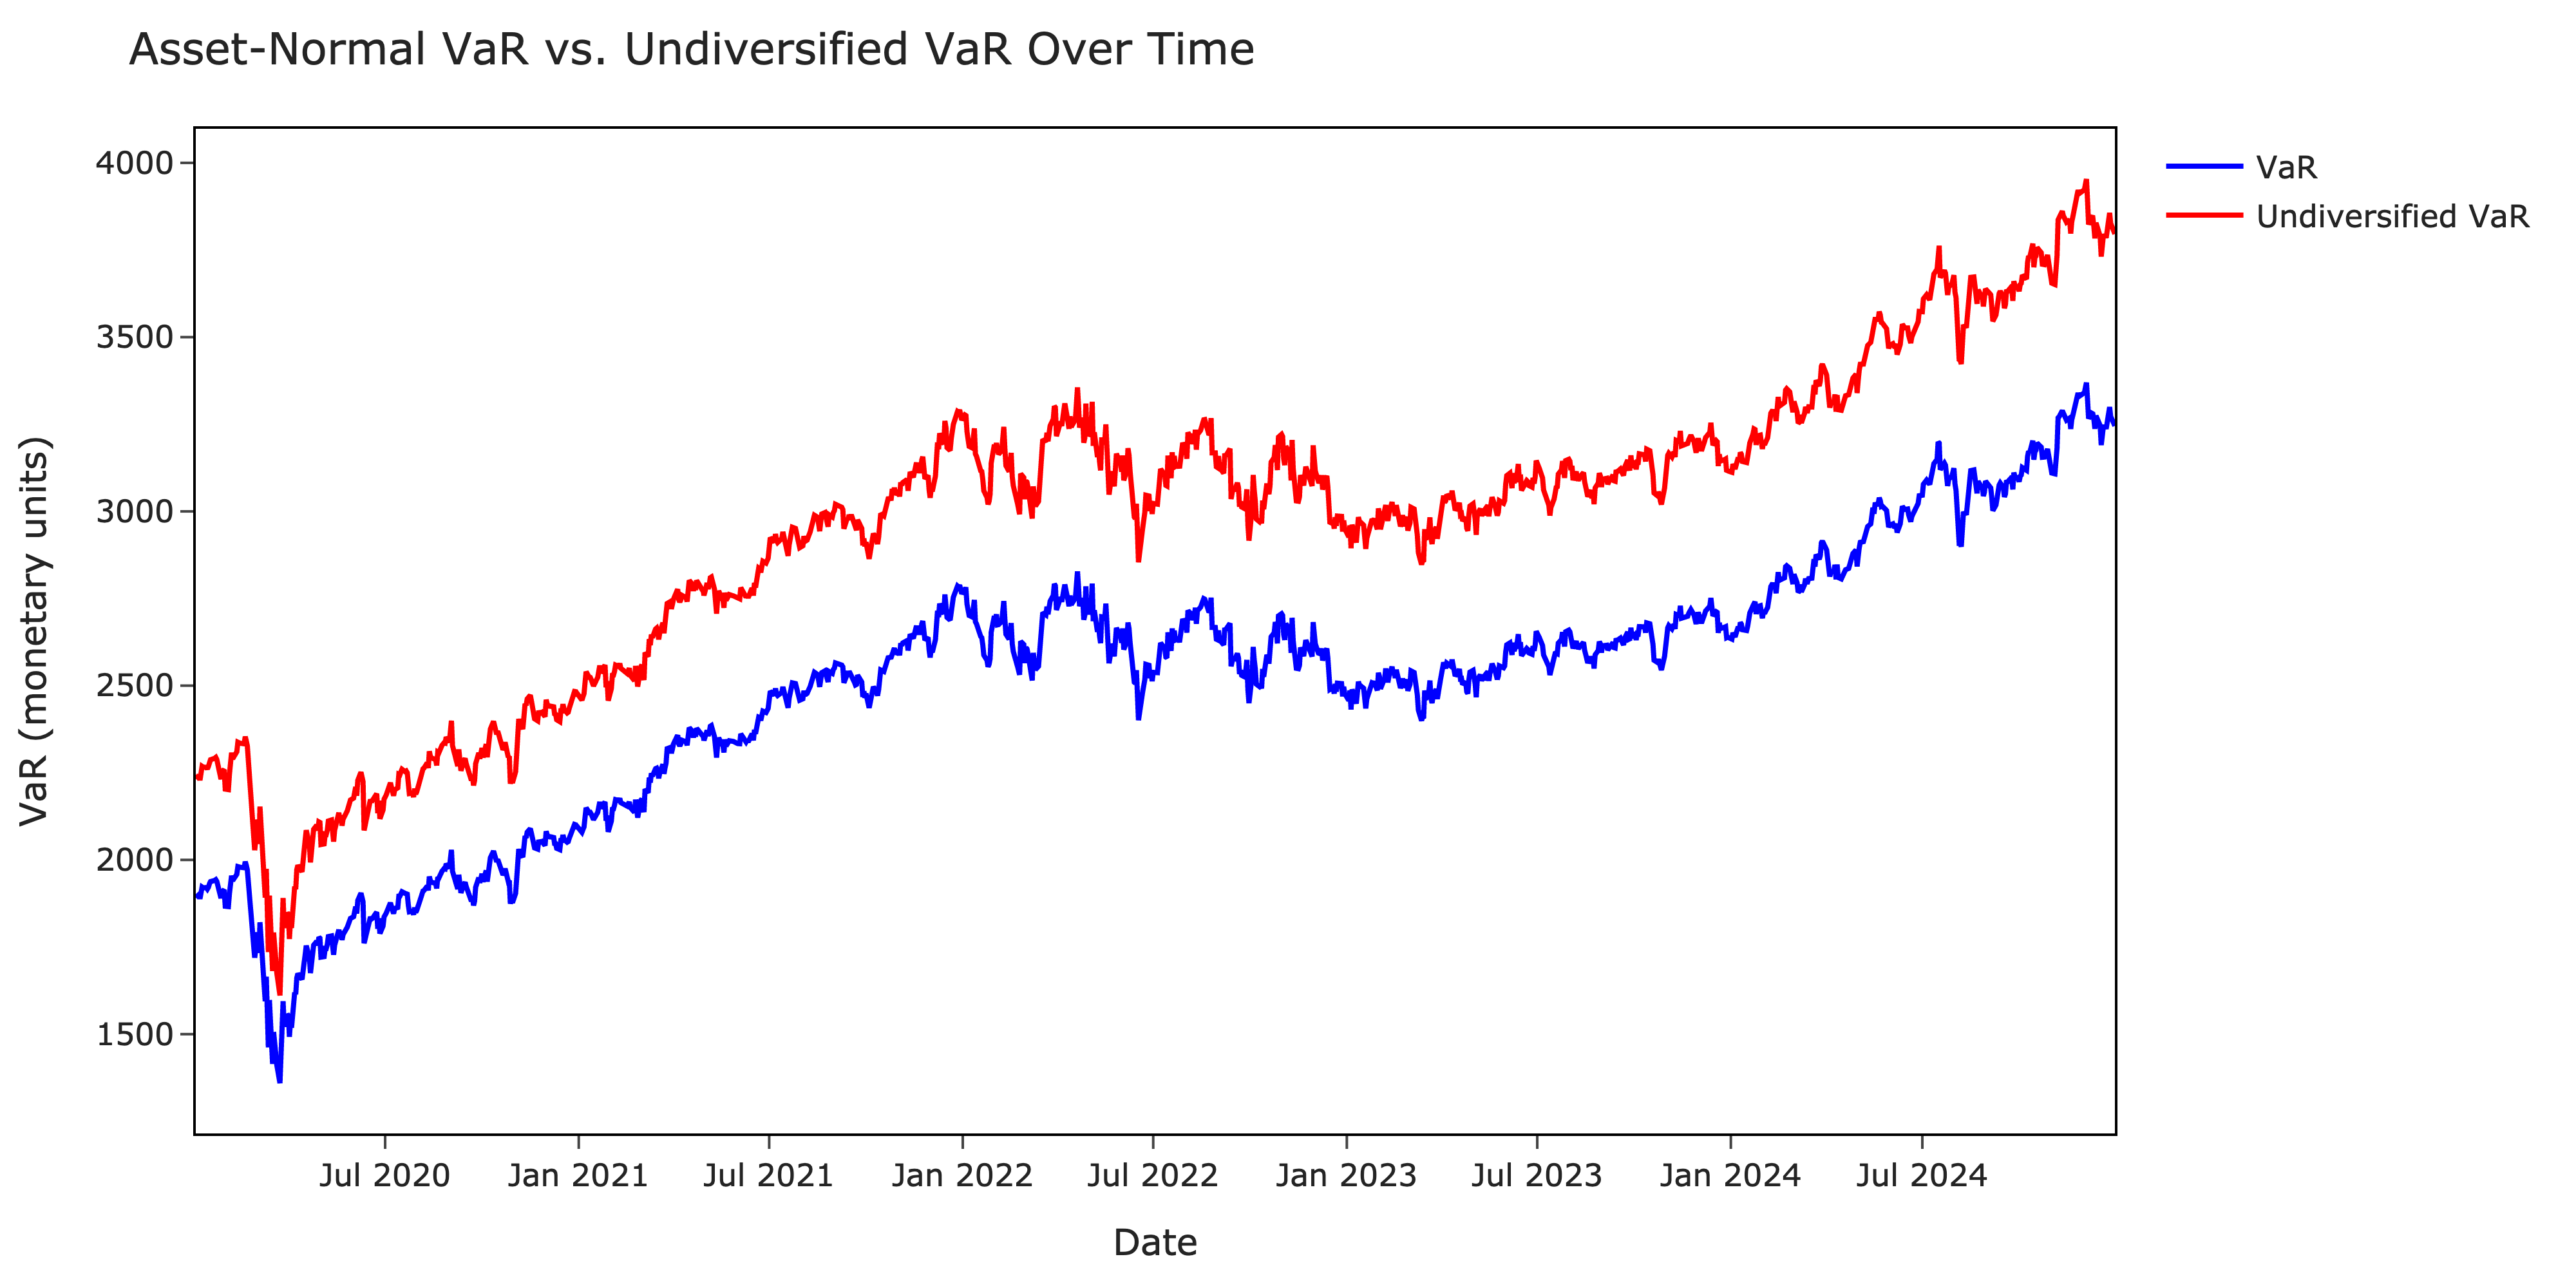

In [25]:
pv.plot_var_series(asset_normal_results, interactive=False)

- **Marginal VaR**  
  $$
  \Delta \text{VaR}_{i,t} = \text{VaR}_t \cdot \frac{(\Sigma x_t)_i}{x_t^\top \Sigma x_t}
  $$

- **Component VaR**  
  $$
  \text{CVaR}_{i,t} = x_{i,t} \cdot \Delta \text{VaR}_{i,t}
  $$

In [26]:
# Compute and display Component VaR (styled table)
component_df = pv.component_var(
    position_data=portfolio_matrix,
    confidence_level=confidence_level
)

In [27]:
component_df.head()

AAPL        EWJ         JNJ        NVS         PG  \
Date                                                                  
2020-01-03  131.807989  49.692092  130.363326  48.592709  94.900491   
2020-01-06  132.909264  49.877025  130.185927  48.930946  95.033486   
2020-01-07  131.878241  49.814503  130.648473  48.292125  94.159875   
2020-01-08  134.024180  49.796323  130.618498  48.288189  94.557058   
2020-01-09  137.663289  50.399543  131.540333  48.639634  96.037276   

                   SPY         UNH        VGK          VT        VWO  \
Date                                                                   
2020-01-03  737.208644  362.288536  86.559154  260.574648  59.674672   
2020-01-06  740.209276  365.040200  86.902208  261.598390  59.576416   
2020-01-07  735.902244  361.586549  86.210977  260.010275  59.372766   
2020-01-08  739.760123  370.052904  86.400606  261.015462  59.617894   
2020-01-09  748.500842  368.947811  86.907346  263.597943  60.220467   

                  XLI  
Date                   
2020-01-03 -69.815784  
2020-01-06 -69.858860  
2020-01-07 -69.505552  
2020-01-08 -69.736671  
2020-01-09 -70.358153


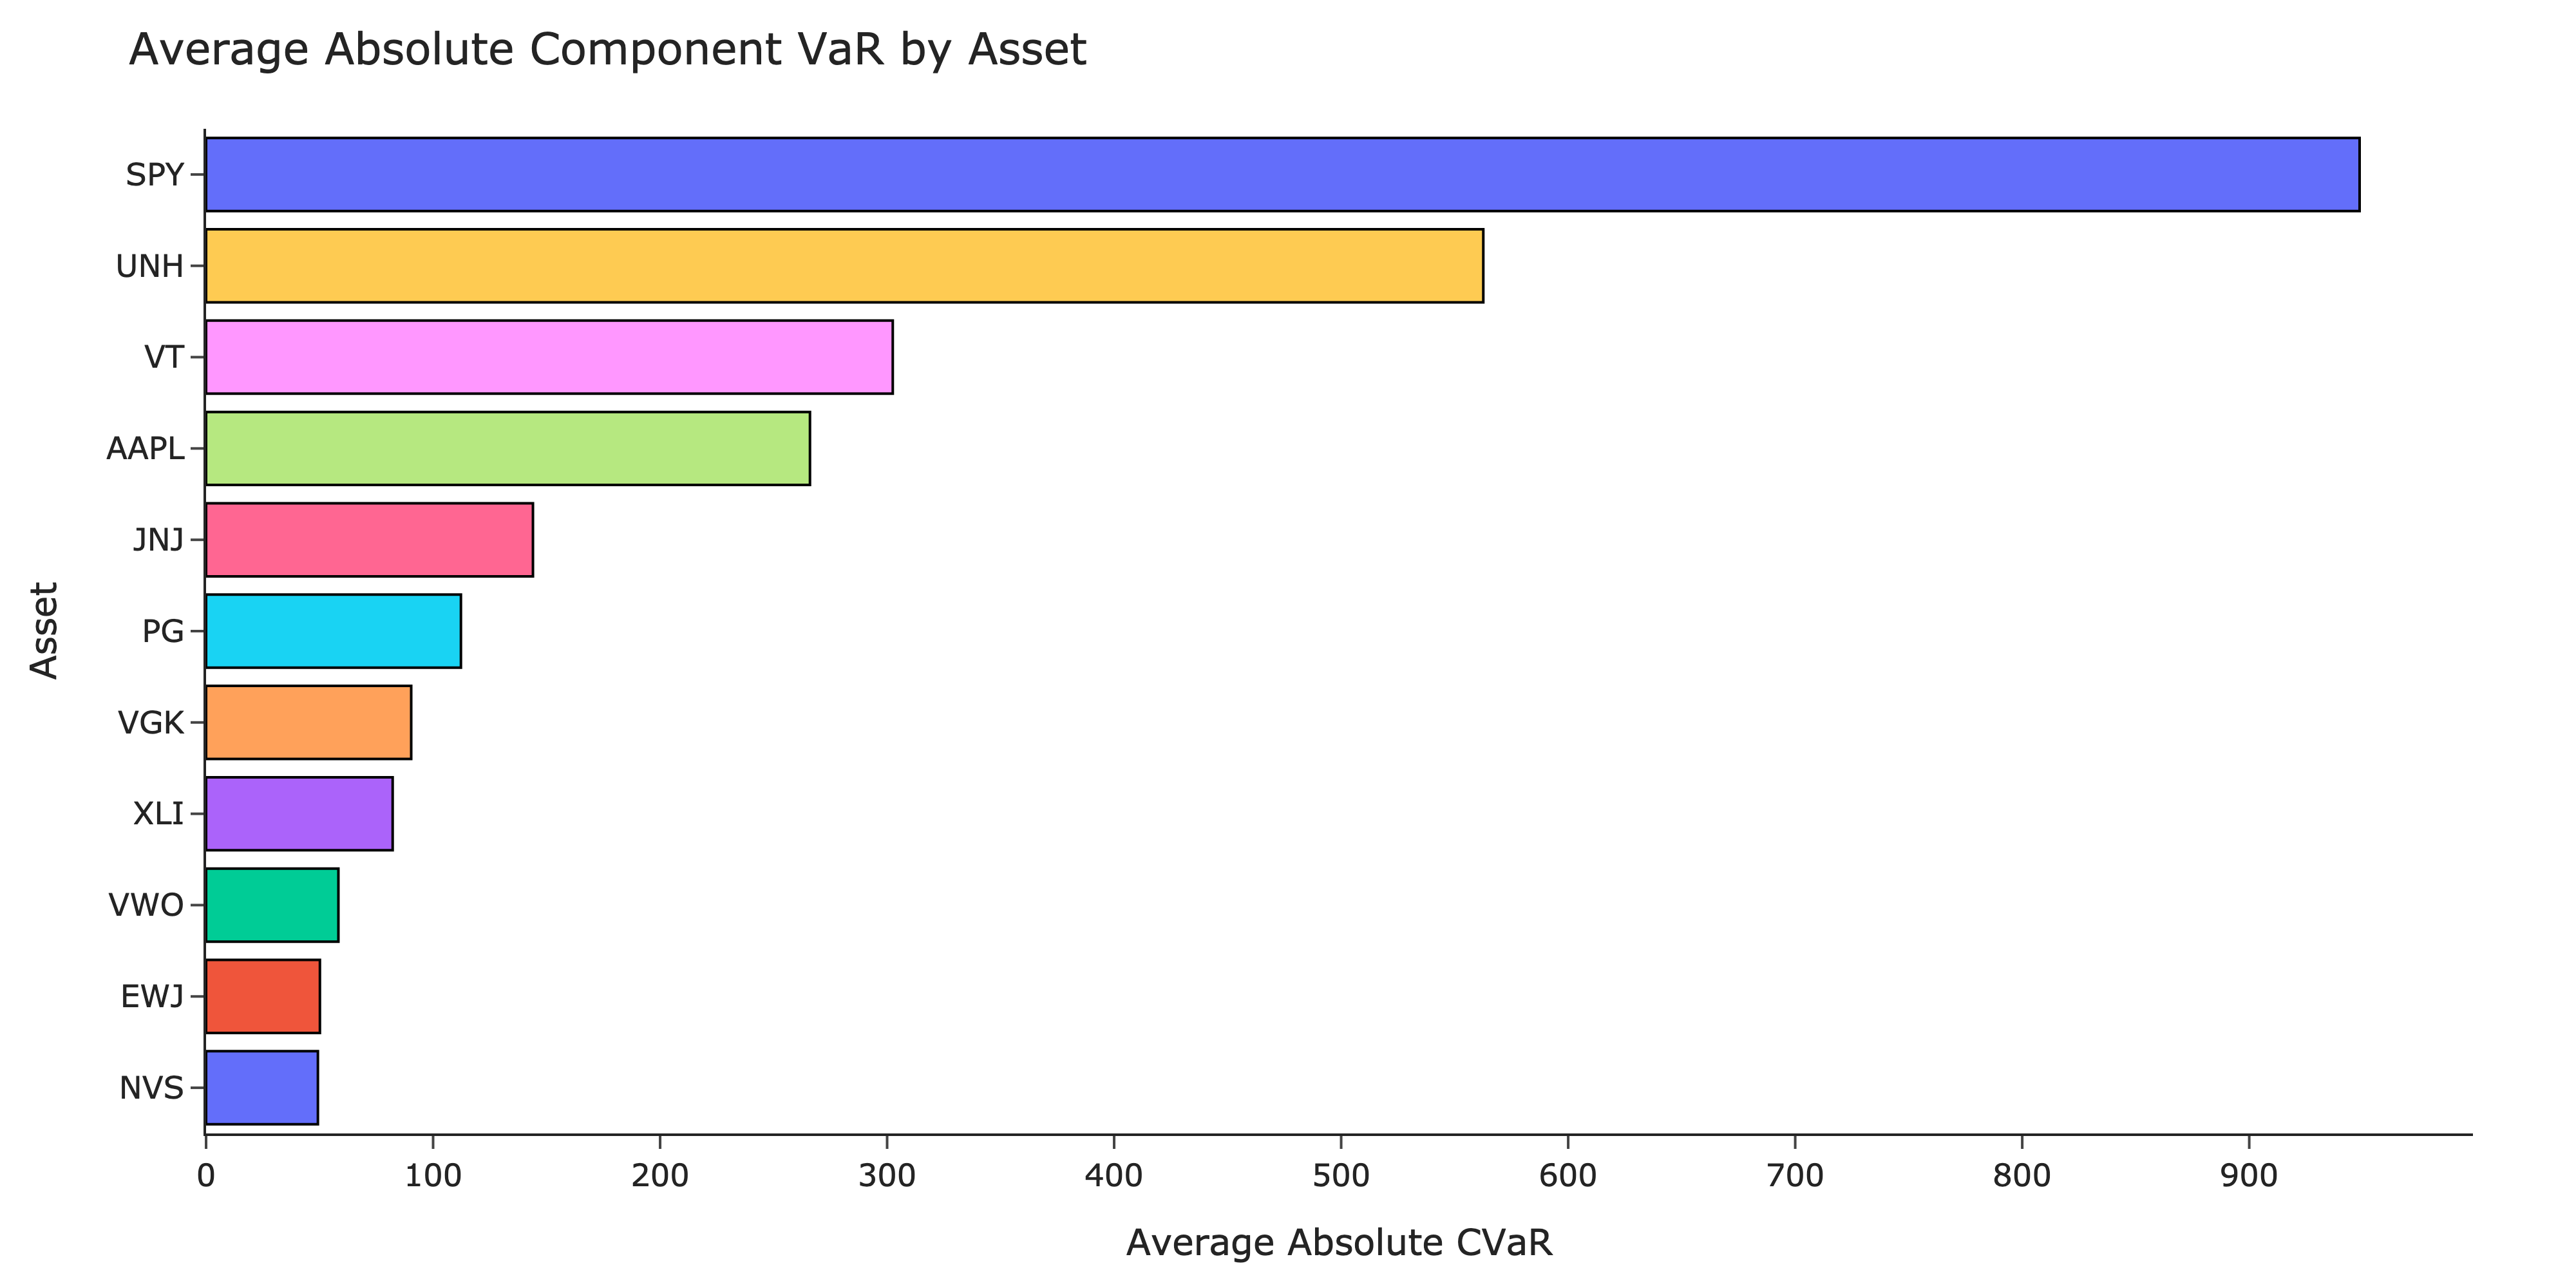

In [28]:
pv.plot_risk_contribution_bar(component_df, interactive=False)


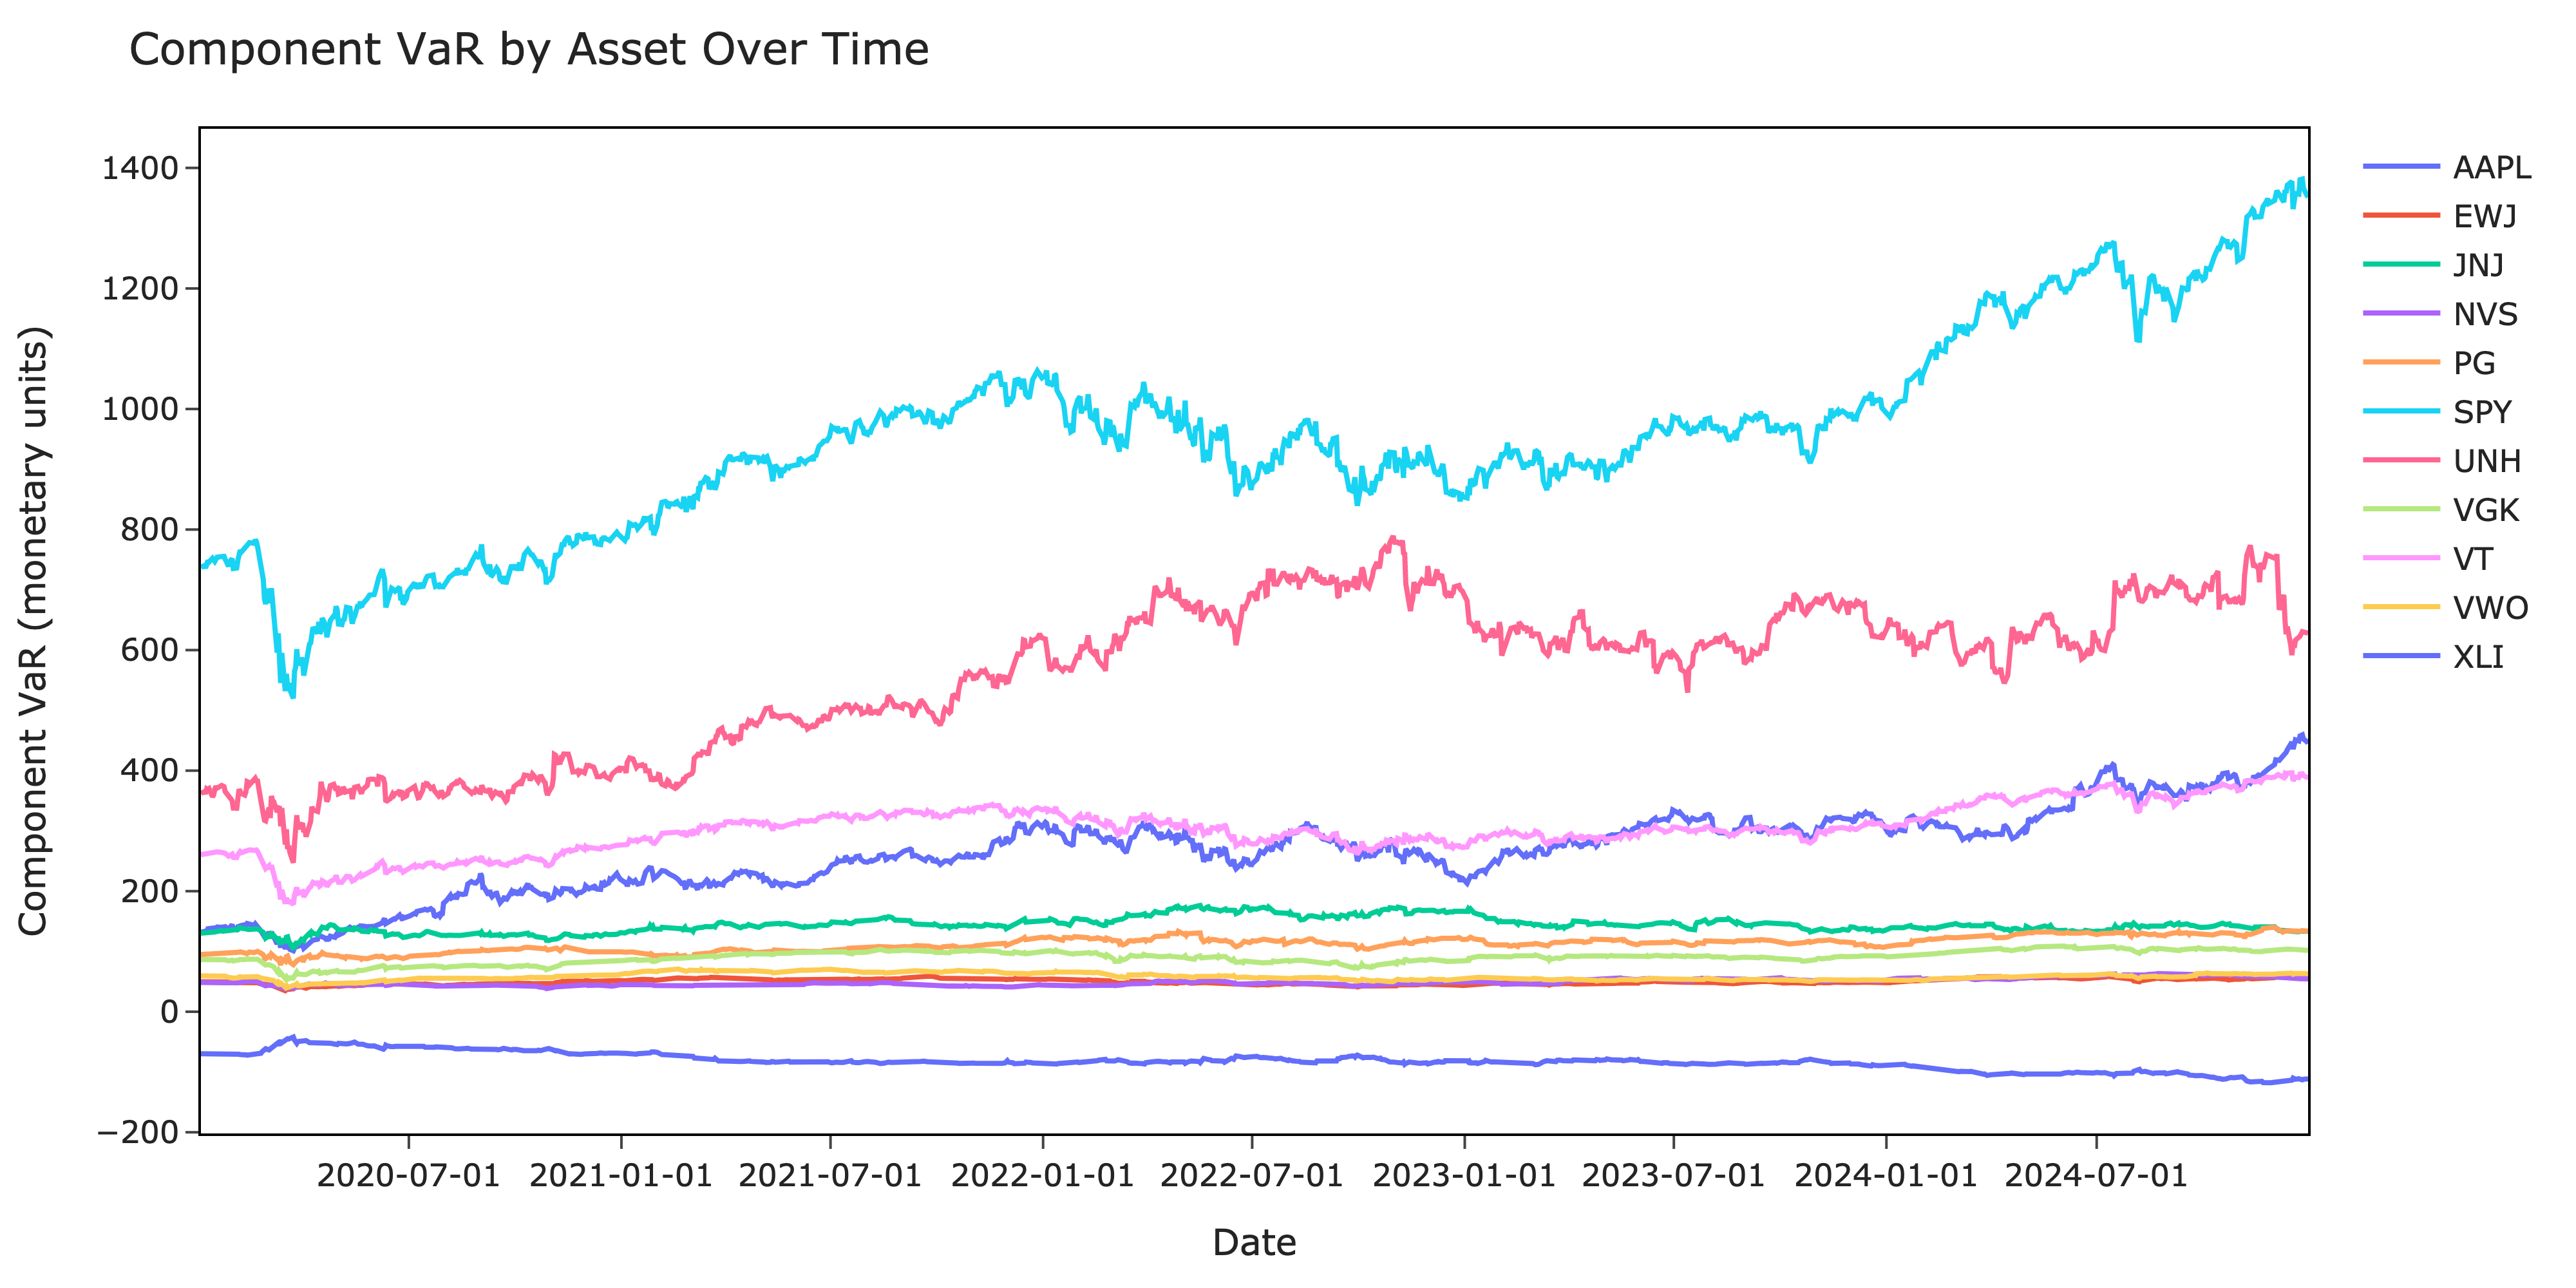

In [29]:
pv.plot_risk_contribution_lines(component_df, interactive=False)

- **Incremental VaR**  
  $$
  \text{IVaR}_t = \Delta \text{VaR}_t^\top \cdot a
  $$


In [30]:
# Define change in position
change_vector = [0,10_000_000,0,0,0,0,0,0,0,0,0] # 10M CHF in SPY

# Compute and display Incremental VaR
ivar_series = pv.incremental_var(
    position_data=portfolio_matrix,
    change_vector=change_vector,
    confidence_level=confidence_level
)

In [31]:
ivar_series

Date
2020-01-03    235901.849809
2020-01-06    235874.819454
2020-01-07    235906.911010
2020-01-08    235700.906130
2020-01-09    235820.810957
                  ...      
2024-12-24    233131.535207
2024-12-26    233051.973995
2024-12-27    233035.667060
2024-12-30    232993.135897
2024-12-31    232998.816956
Length: 1257, dtype: float64

### Time Varying Correlation Models

In [32]:
# Run RiskMetrics Correlation VaR
result_ewma_correlation = pv.ewma_correlation_var(portfolio_matrix, distribution="empirical")

# ES RiskMetrics
result_ewma_correlation = pv.correlation_es(result_ewma_correlation)

In [33]:
result_ewma_correlation.head(-4)

Returns  Volatility  Innovations       VaR  VaR Monetary  \
2020-01-03 -0.005550    0.012599    -0.440484  0.029931   1884.096886   
2020-01-06  0.004210    0.012262     0.343307  0.029132   1841.464909   
2020-01-07 -0.006042    0.011977    -0.504441  0.028454   1787.767218   
2020-01-08  0.007711    0.011775     0.654842  0.027973   1770.993556   
2020-01-09  0.009382    0.011644     0.805788  0.027662   1767.655905   
...              ...         ...          ...       ...           ...   
2024-12-18 -0.017276    0.008246    -2.095053  0.019590   2005.396531   
2024-12-19  0.006980    0.008157     0.855789  0.019378   1997.358102   
2024-12-20  0.008414    0.008185     1.027957  0.019446   2021.124544   
2024-12-23  0.000003    0.007943     0.000336  0.018869   1961.142294   
2024-12-24  0.013300    0.008357     1.591449  0.019855   2090.998244   

            VaR Violation        ES  ES Monetary  
2020-01-03          False  0.034526  2173.300731  
2020-01-06          False  0.033603  2124.124859  
2020-01-07          False  0.032822  2062.184716  
2020-01-08          False  0.032267  2042.836342  
2020-01-09          False  0.031908  2038.986370  
...                   ...       ...          ...  
2024-12-18          False  0.022597  2313.219548  
2024-12-19          False  0.022352  2303.947241  
2024-12-20          False  0.022431  2331.361769  
2024-12-23          False  0.021765  2262.172404  
2024-12-24          False  0.022902  2411.960896  

[1253 rows x 8 columns]

In [51]:
# Plot RiskMetrics model results
fig_rm_es = pv.plot_backtest(result_ewma_correlation, interactive=True)

In [35]:
# Count violations
ewma_corr_violations, ewma_corr_violation_rate = pv.count_violations(result_ewma_correlation)

# Kupiec Test (Unconditional Coverage)
ewma_corr_kupiec = pv.kupiec_test(
    total_violations=ewma_corr_violations,
    total_days=len(result_ewma_correlation),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
ewma_corr_christoffersen = pv.christoffersen_test(result_ewma_correlation)

# Joint Test (Conditional Coverage)
ewma_corr_joint = pv.joint_lr_test(
    LR_uc=ewma_corr_kupiec["LR_uc"],
    LR_c=ewma_corr_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- RiskMetrics Correlation VaR Backtesting Summary ---")
print(f"Total Violations     : {ewma_corr_violations}")
print(f"Violation Rate       : {ewma_corr_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {ewma_corr_kupiec['LR_uc']:.4f}")
print(f"p-value             : {ewma_corr_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {ewma_corr_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {ewma_corr_christoffersen['LR_c']:.4f}")
print(f"p-value             : {ewma_corr_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {ewma_corr_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {ewma_corr_joint['LR_total']:.4f}")
print(f"p-value             : {ewma_corr_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {ewma_corr_joint['reject_null']}")



--- RiskMetrics Correlation VaR Backtesting Summary ---
Total Violations     : 13
Violation Rate       : 1.03%

Kupiec Test (UC):
LR_uc               : 0.0147
p-value             : 0.9035
Reject Null (5%)    : False

Christoffersen Test (Independence):
LR_c                : 0.2719
p-value             : 0.6020
Reject Null (5%)    : False

Joint Test (Conditional Coverage):
LR_total            : 0.2866
p-value             : 0.8665
Reject Null (5%)    : False


### Factor Models

We do the single factor model. SMI is used as benchmark.

The Single-Factor model assumes that all asset returns are driven by a single common factor — typically the market index.  
This is also referred to as the **Sharpe Single-Index Model**, and is a special case of the delta-normal method.

Each asset’s return is modeled as:

$$
R_i = \alpha_i + \beta_i R_m + \varepsilon_i
$$

where:
- $R_m$ is the market return
- $\beta_i$ is the sensitivity of asset $i$ to the market
- $\varepsilon_i$ is the idiosyncratic (asset-specific) risk

The total variance of asset $i$ is:

$$
\sigma_i^2 = \beta_i^2 \sigma_m^2 + \sigma_{\varepsilon_i}^2
$$

The portfolio’s covariance matrix is approximated as:

$$
\Sigma = \beta \beta^T \cdot \sigma_m^2 + D
$$

where:
- $\beta$: vector of asset betas
- $\sigma_m^2$: variance of the market return
- $D$: diagonal matrix of idiosyncratic variances

Finally, the portfolio VaR at confidence level $\alpha$ is given by:

$$
\text{VaR}_{\alpha} = z_\alpha \cdot \sigma_p \cdot \text{PortfolioValue}
$$

and the Expected Shortfall (ES) is:

$$
\text{ES}_{\alpha} = \frac{\phi(z_\alpha)}{1 - \alpha} \cdot \sigma_p \cdot \text{PortfolioValue}
$$

where $z_\alpha$ is the quantile of the standard normal distribution and $\phi$ is the standard normal PDF.


In [36]:
# Download SMI index prices (already in CHF)
smi_data = yf.download("^SSMI", start="2019-12-30", end="2025-01-01")["Close"]

# Ensure Series (in case yfinance returns a DataFrame)
if isinstance(smi_data, pd.DataFrame):
    smi_data = smi_data.squeeze()

# Compute benchmark returns
benchmark = smi_data.pct_change().dropna()

# Align benchmark with asset returns
benchmark = benchmark.reindex(portfolio_returns.index).ffill()

[*********************100%***********************]  1 of 1 completed


In [37]:
benchmark.head()

Date
2020-01-03    0.007806
2020-01-06   -0.003216
2020-01-07    0.002006
2020-01-08   -0.003241
2020-01-09   -0.000112
Name: ^SSMI, dtype: float64

In [38]:
print("Benchmark type:", type(benchmark))
print("Benchmark ndim:", benchmark.ndim)
print("Benchmark shape:", benchmark.shape)
print("Portfolio returns shape:", portfolio_returns.shape)
print("Index equal:", benchmark.index.equals(portfolio_returns.index))
print("Any NaNs in benchmark:", benchmark.isna().any())


Benchmark type: <class 'pandas.core.series.Series'>
Benchmark ndim: 1
Benchmark shape: (1257,)
Portfolio returns shape: (1257, 11)
Index equal: True
Any NaNs in benchmark: False


In [39]:
results_one_factor_df, portfolio_volatility = pv.single_factor_var(
    returns=portfolio_returns,
    benchmark=benchmark,
    weights=weights,
    portfolio_value=103_280,
    confidence_level=confidence_level
)

results_one_factor_df = pv.factor_models_es(
    result_data= results_one_factor_df,
    portfolio_volatility=portfolio_volatility,
    confidence_level = confidence_level
)


In [40]:
results_one_factor_df.head()

Returns  Benchmark       VaR  VaR Violation  VaR_monetary  \
Date                                                                     
2020-01-03 -0.005368   0.007806  0.031181          False   3220.376237   
2020-01-06  0.004687  -0.003216  0.031181          False   3220.376237   
2020-01-07 -0.006421   0.002006  0.031181          False   3220.376237   
2020-01-08  0.008745  -0.003241  0.031181          False   3220.376237   
2020-01-09  0.010256  -0.000112  0.031181          False   3220.376237   

                  ES  ES_monetary  
Date                               
2020-01-03  0.035723  3689.470795  
2020-01-06  0.035723  3689.470795  
2020-01-07  0.035723  3689.470795  
2020-01-08  0.035723  3689.470795  
2020-01-09  0.035723  3689.470795


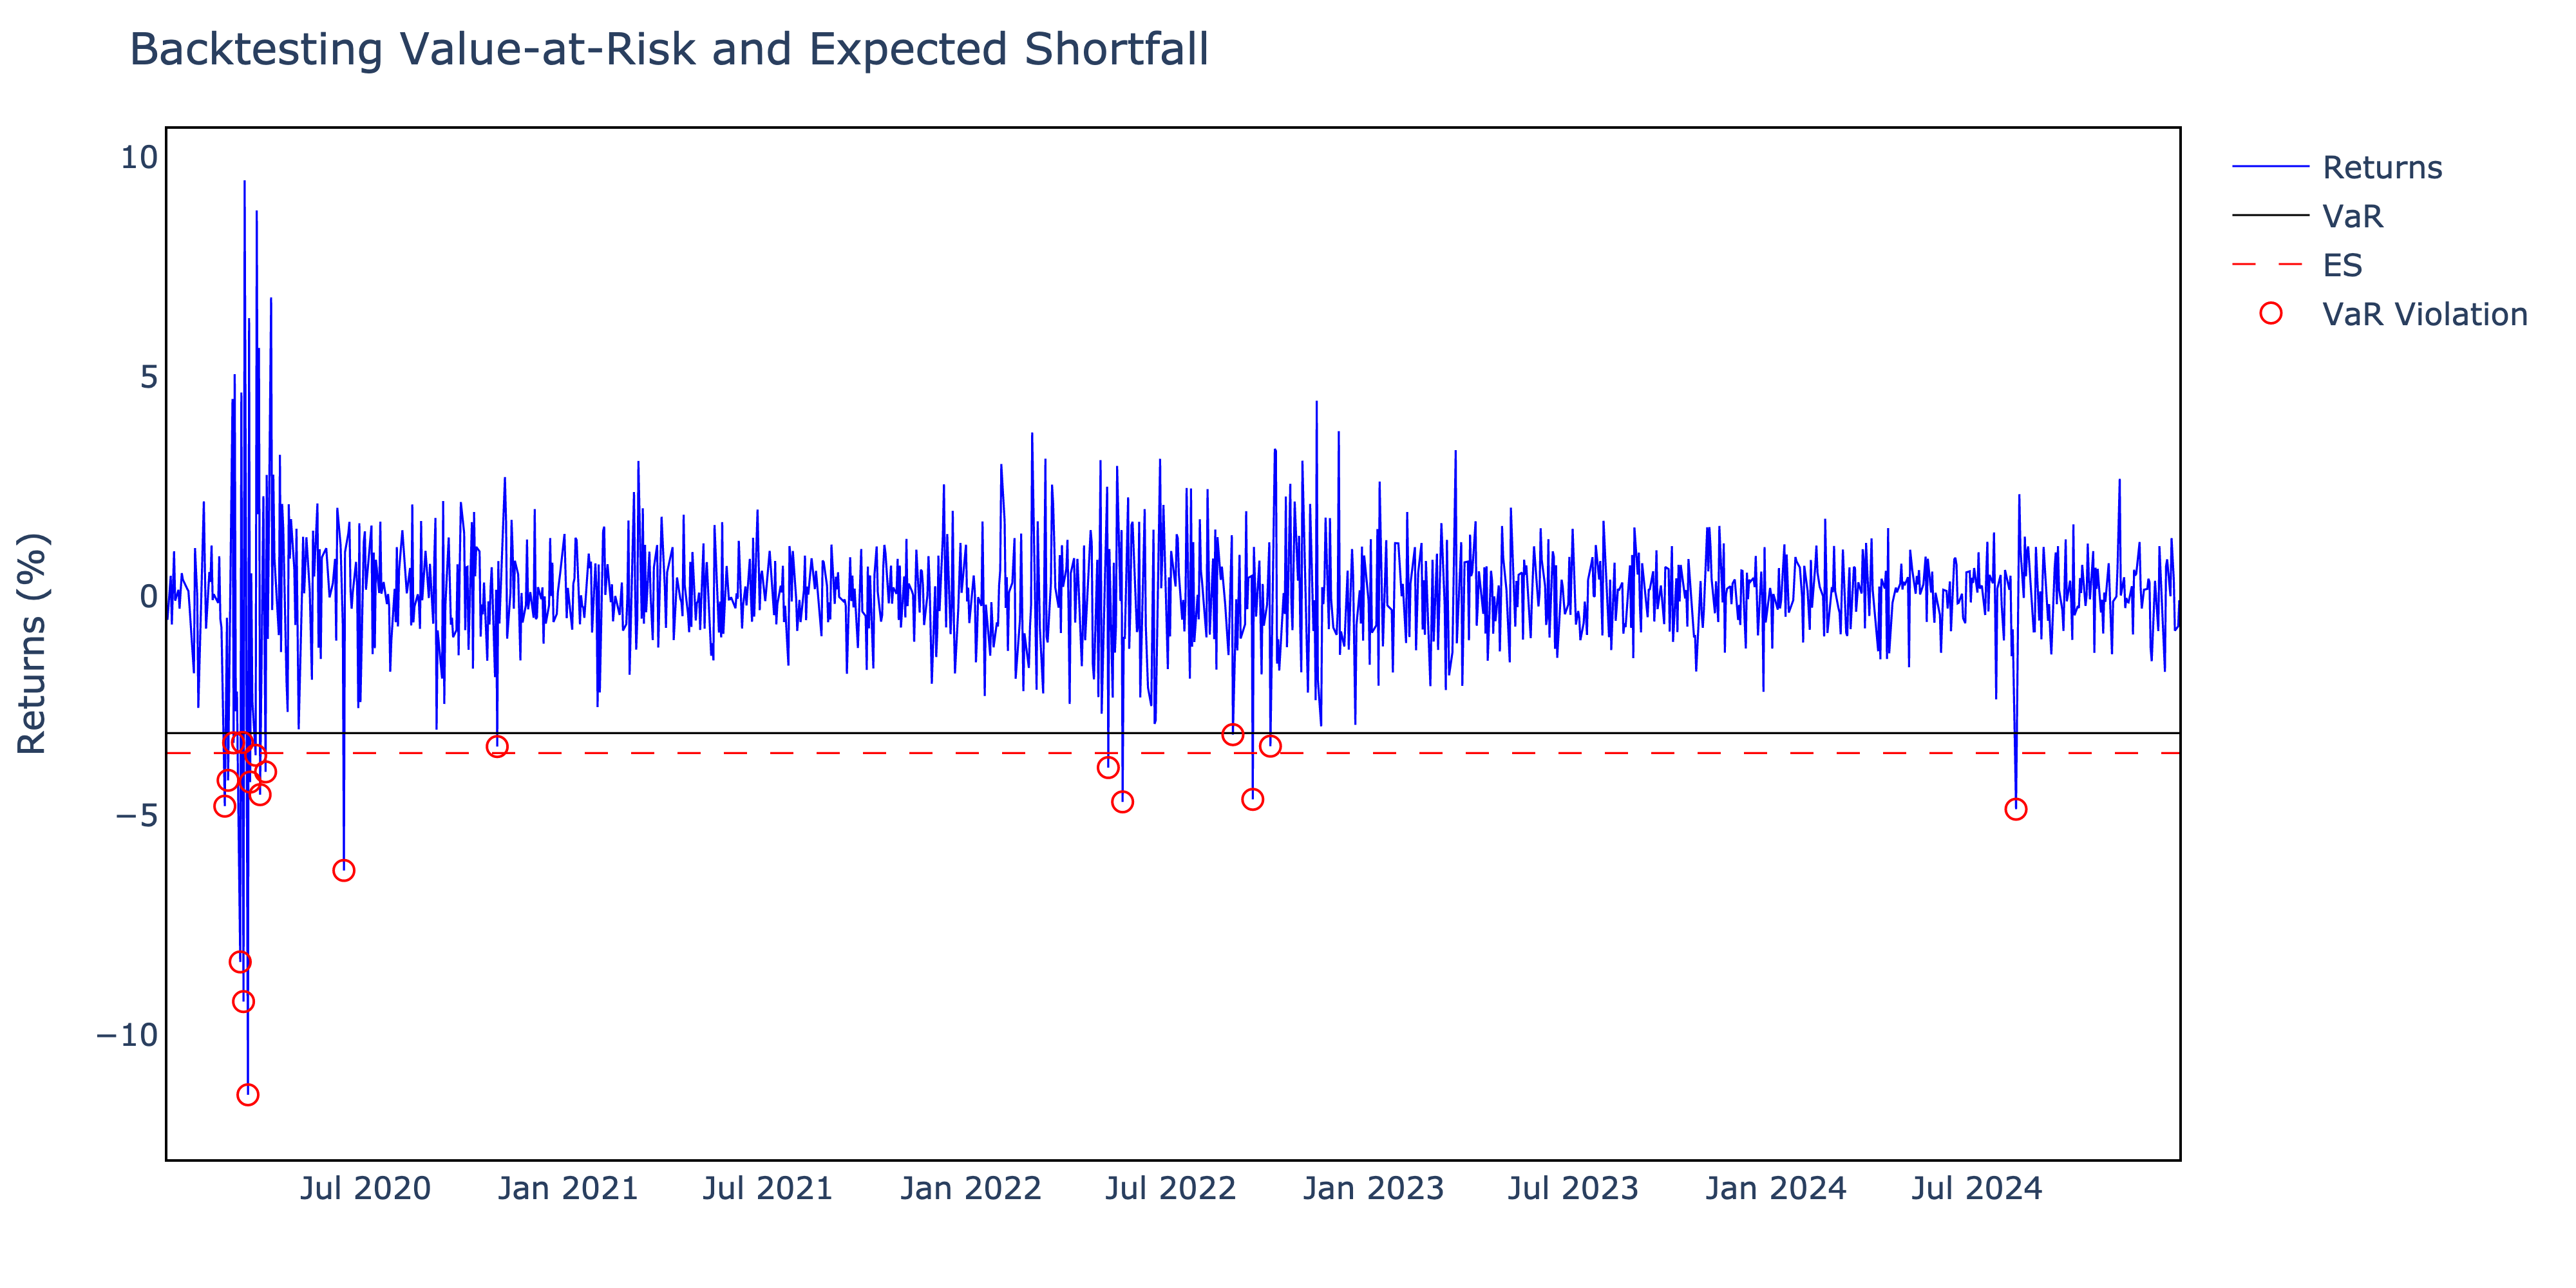

In [41]:
# Plot backtest
fig_var = pv.plot_backtest(results_one_factor_df, interactive=False)

In [42]:
# Count violations
sf_violations, sf_violation_rate = pv.count_violations(results_one_factor_df)

# Kupiec Test (Unconditional Coverage)
sf_kupiec = pv.kupiec_test(
    total_violations=sf_violations,
    total_days=len(results_one_factor_df),
    confidence_level=confidence_level
)

# Christoffersen Test (Independence)
sf_christoffersen = pv.christoffersen_test(results_one_factor_df)

# Joint Test (Conditional Coverage)
sf_joint = pv.joint_lr_test(
    LR_uc=sf_kupiec["LR_uc"],
    LR_c=sf_christoffersen["LR_c"]
)

# Summary output
print(f"\n--- Single-Factor VaR Backtesting Summary ---")
print(f"Total Violations     : {sf_violations}")
print(f"Violation Rate       : {sf_violation_rate * 100:.2f}%\n")

print("Kupiec Test (UC):")
print(f"LR_uc               : {sf_kupiec['LR_uc']:.4f}")
print(f"p-value             : {sf_kupiec['p_value']:.4f}")
print(f"Reject Null (5%)    : {sf_kupiec['reject_null']}")

print("\nChristoffersen Test (Independence):")
print(f"LR_c                : {sf_christoffersen['LR_c']:.4f}")
print(f"p-value             : {sf_christoffersen['p_value']:.4f}")
print(f"Reject Null (5%)    : {sf_christoffersen['reject_null']}")

print("\nJoint Test (Conditional Coverage):")
print(f"LR_total            : {sf_joint['LR_total']:.4f}")
print(f"p-value             : {sf_joint['p_value']:.4f}")
print(f"Reject Null (5%)    : {sf_joint['reject_null']}")



--- Single-Factor VaR Backtesting Summary ---
Total Violations     : 19
Violation Rate       : 1.51%

Kupiec Test (UC):
LR_uc               : 2.8721
p-value             : 0.0901
Reject Null (5%)    : False

Christoffersen Test (Independence):
LR_c                : 1.1238
p-value             : 0.2891
Reject Null (5%)    : False

Joint Test (Conditional Coverage):
LR_total            : 3.9959
p-value             : 0.1356
Reject Null (5%)    : False


### Simulations

Start by defining options.

This simulation estimates 1-day **VaR** and **ES** using a parametric Monte Carlo approach.

#### Assumptions:

- Asset returns follow a **multivariate normal distribution**  
- One-step horizon of 1 trading day: $\Delta t = \frac{1}{252}$  
- Expected returns $\mu$ and covariance matrix $\Sigma$ estimated from historical data  
- The portfolio includes both linear (stocks) and nonlinear instruments (European options)

---

#### Simulation Steps:

1. Generate $N$ scenarios of daily returns:
   $$
   R_i \sim \mathcal{N}(\mu, \Sigma), \quad i = 1, \dots, N
   $$

2. Compute simulated asset prices:
   $$
   S_i = S_0 \cdot (1 + R_i)
   $$

3. For each scenario $i$, compute portfolio P&L including:
   - equity P&L from price differences  
   - option P&L from repricing via Black-Scholes:
     $$
     C(S_i, K, T - \Delta t, r, \sigma)
     $$

4. Construct the empirical distribution of P&L across all $N$ scenarios

5. Compute:

- **VaR** at level $\alpha$ (as a positive number):

  $$
  \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
  $$

- **CVaR** (Expected Shortfall):

  $$
  \text{CVaR}_\alpha = -\mathbb{E}\left[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})\right]
  $$

---

This approach captures the full distribution of outcomes including nonlinear payoffs, but only for a single-day shock.


In [43]:
# Use existing spot prices and volatilities
S0 = prices_chf.iloc[-1]
volatility_annualized = portfolio_returns.std() * np.sqrt(252)

# Select representative tickers for options
selected_tickers = ["VT", "SPY", "AAPL", "JNJ", "XLI"]

# Create example option contracts
options = [
    {
        "asset_index": tickers.index("AAPL"),
        "K": 200,
        "T": 60 / 252,
        "r": 0.01,
        "sigma": volatility_annualized["AAPL"],
        "type": "call",
        "qty": 30
    },
    {
        "asset_index": tickers.index("XLI"),
        "K": 90,
        "T": 45 / 252,
        "r": 0.01,
        "sigma": volatility_annualized["XLI"],
        "type": "put",
        "qty": 50
    },
    {
        "asset_index": tickers.index("VT"),
        "K": 100,
        "T": 90 / 252,
        "r": 0.01,
        "sigma": volatility_annualized["VT"],
        "type": "call",
        "qty": 25
    }
]

# Print values of equity positions (already defined)
print("\nEquity Positions (latest prices):")
total_equity_value = 0
for tkr in tickers:
    position_value = shares[tkr] * S0[tkr]
    print(f"{tkr:5}: {shares[tkr]:4} × {S0[tkr]:.2f} = {position_value:,.2f} CHF")
    total_equity_value += position_value

# Price and print values of options
print("\nOption Values (Black-Scholes at time 0):")
total_option_value = 0
for i, opt in enumerate(options):
    spot = S0[tickers[opt["asset_index"]]]
    price_bs = pv.black_scholes(
        spot, opt["K"], opt["T"], opt["r"], opt["sigma"], opt["type"]
    )
    value = price_bs * opt["qty"]
    print(f"Option {i+1} on {tickers[opt['asset_index']]} ({opt['type']}): "
          f"BS = {price_bs:.2f} × {opt['qty']} = {value:,.2f} CHF")
    total_option_value += value

# Print new portfolio value
total_portfolio_value = total_equity_value + total_option_value
print(f"\nTotal equity value:     {total_equity_value:,.2f} CHF")
print(f"Total option value:     {total_option_value:,.2f} CHF")
print(f"Total portfolio value:  {total_portfolio_value:,.2f} CHF")



Equity Positions (latest prices):
VT   :  120 × 105.77 = 12,692.06 CHF
SPY  :   80 × 527.78 = 42,222.66 CHF
VGK  :   60 × 57.10 = 3,425.81 CHF
EWJ  :   40 × 60.61 = 2,424.30 CHF
VWO  :   60 × 39.74 = 2,384.30 CHF
AAPL :   50 × 225.65 = 11,282.25 CHF
JNJ  :   50 × 129.59 = 6,479.46 CHF
PG   :   40 × 149.58 = 5,983.12 CHF
UNH  :   40 × 454.97 = 18,198.74 CHF
NVS  :   30 × 84.74 = 2,542.25 CHF
XLI  :  -30 × 118.65 = -3,559.39 CHF

Option Values (Black-Scholes at time 0):
Option 1 on AAPL (call): BS = 30.43 × 30 = 912.95 CHF
Option 2 on XLI (put): BS = 0.01 × 50 = 0.65 CHF
Option 3 on VT (call): BS = 8.99 × 25 = 224.70 CHF

Total equity value:     104,075.56 CHF
Total option value:     1,138.29 CHF
Total portfolio value:  105,213.85 CHF


Monte Carlo.

In [44]:
# Run Parametric Monte Carlo VaR and ES (1-day, 99% level)
var_mc, pnl_mc = pv.monte_carlo_var(
    price_data=prices_chf,  # ensure correct order
    shares=shares,
    options=options,
    confidence_level=confidence_level,
    simulations=10_000,
    seed=1
)

es_mc = pv.simulation_es(var_mc, pnl_mc)

# Display Monte Carlo Results
print(f"Monte Carlo VaR ({int(confidence_level * 100)}%):  {var_mc:,.2f} CHF")
print(f"Monte Carlo ES ({int(confidence_level * 100)}%):  {es_mc:,.2f} CHF")

Monte Carlo VaR (99%):  4,021.43 CHF
Monte Carlo ES (99%):  4,550.90 CHF



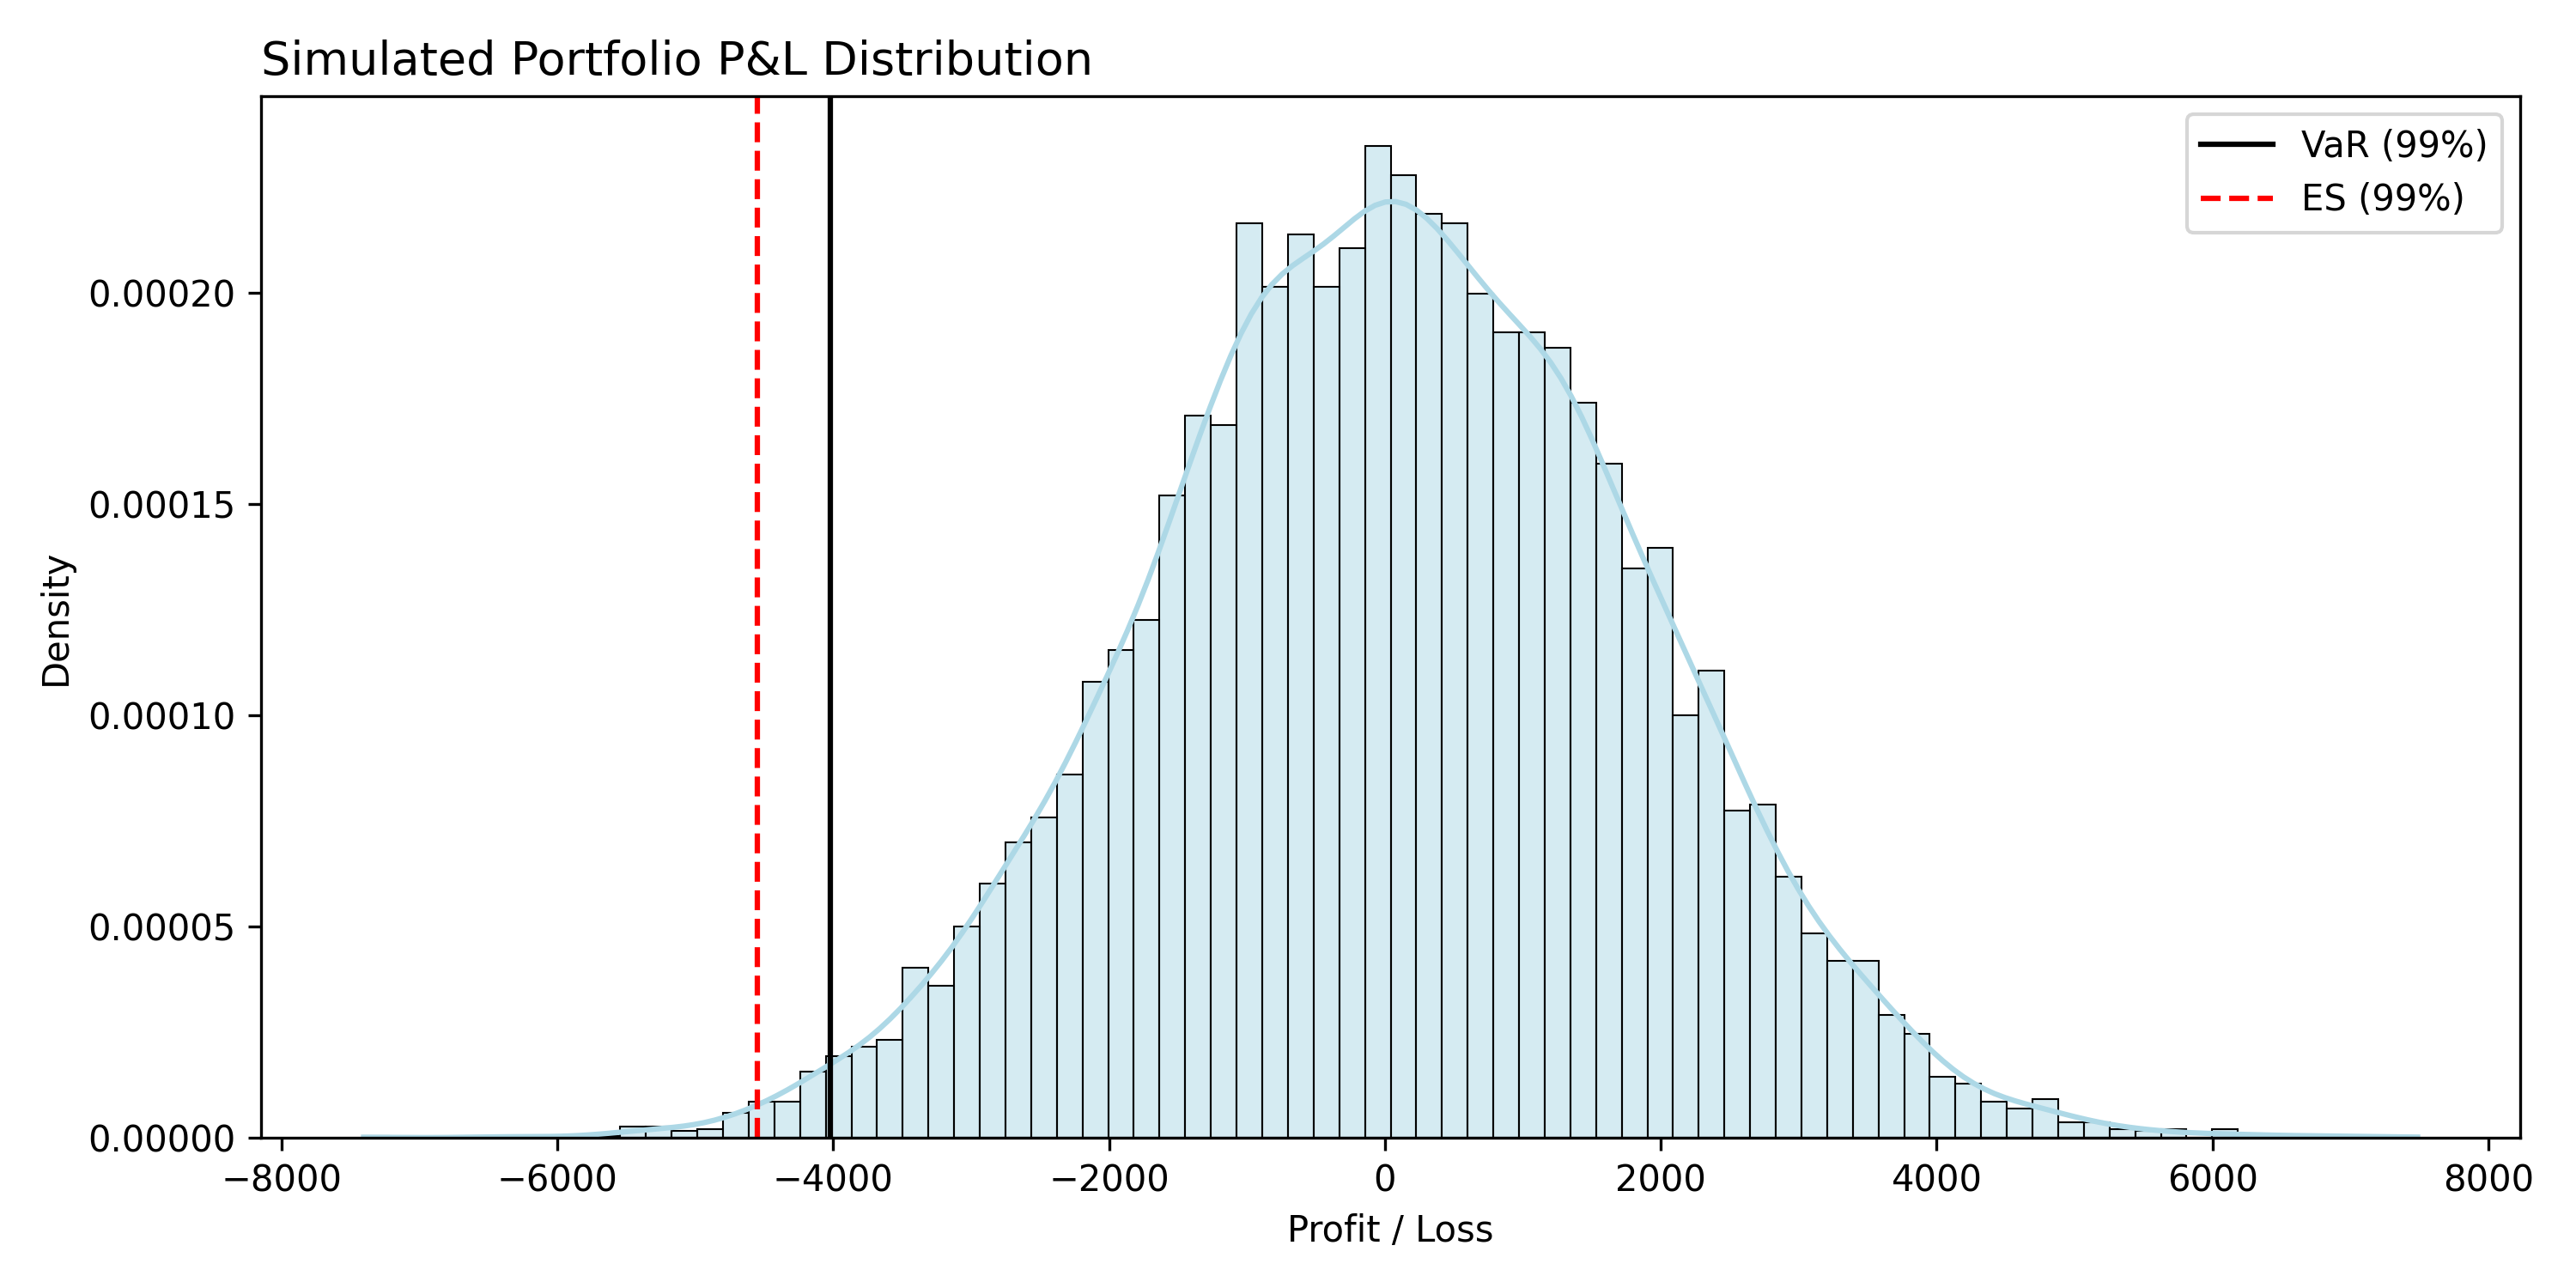

In [45]:
pv.plot_simulated_distribution(
    profit_and_loss=pnl_mc,
    var=var_mc,
    es=es_mc,
    confidence_level=0.99
)


Multiday Monte Carlo.

Unlike the single-day approach, the multi-day simulation explicitly models the **evolution of asset prices over multiple days**.

---

#### Key Differences:

- The simulation runs over $T$ days instead of 1:

  $$
  S^{(i)}_{t+1} = S^{(i)}_t \cdot (1 + R^{(i)}_t), \quad R^{(i)}_t \sim \mathcal{N}(\mu, \Sigma)
  $$

- Correlated random returns are generated at each step using Cholesky decomposition:

  $$
  R_t = \mu + LZ_t, \quad Z_t \sim \mathcal{N}(0, I)
  $$

- Each path $i$ produces a full price trajectory:

  $$
  \{ S_0^{(i)}, S_1^{(i)}, \dots, S_T^{(i)} \}
  $$

- The portfolio value is computed at each step, and final profit/loss is:

  $$
  \text{P\&L}^{(i)} = V_T^{(i)} - V_0
  $$

- VaR and CVaR are estimated from the distribution of final P&L values across all $i = 1, \dots, N$:

  $$
  \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
  $$

  $$
  \text{CVaR}_\alpha = -\mathbb{E}\left[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})\right]
  $$

---

#### Remarks:

- This approach captures the **compounding** of returns and the **path-dependent risk** over time  
- It assumes parameters $(\mu, \Sigma)$ stay constant throughout the simulation horizon  
- Option repricing across time is possible but not included unless explicitly modeled


#### Remarks:

- This approach captures the **compounding** of returns and the **path-dependent risk** over time
- It assumes parameters ($\mu$, $\Sigma$) stay constant throughout the simulation horizon
- Option repricing across time is possible but not included unless explicitly modeled


In [46]:
# Run the simulation
var_mc20, pnl_mc20, portfolio_paths = pv.multiday_monte_carlo_var(
    price_data=prices_chf,  # ensure correct order
    shares=shares, 
    confidence_level=confidence_level,
    days_ahead=20,
)

es_mc = pv.simulation_es(var_mc20, pnl_mc20)

# Print results
print(f"Monte Carlo 20-day VaR (99%):  {var_mc20:,.2f} CHF")
print(f"Monte Carlo 20-day ES  (99%):  {es_mc:,.2f} CHF")


Monte Carlo 20-day VaR (99%):  13,118.64 CHF
Monte Carlo 20-day ES  (99%):  15,044.56 CHF



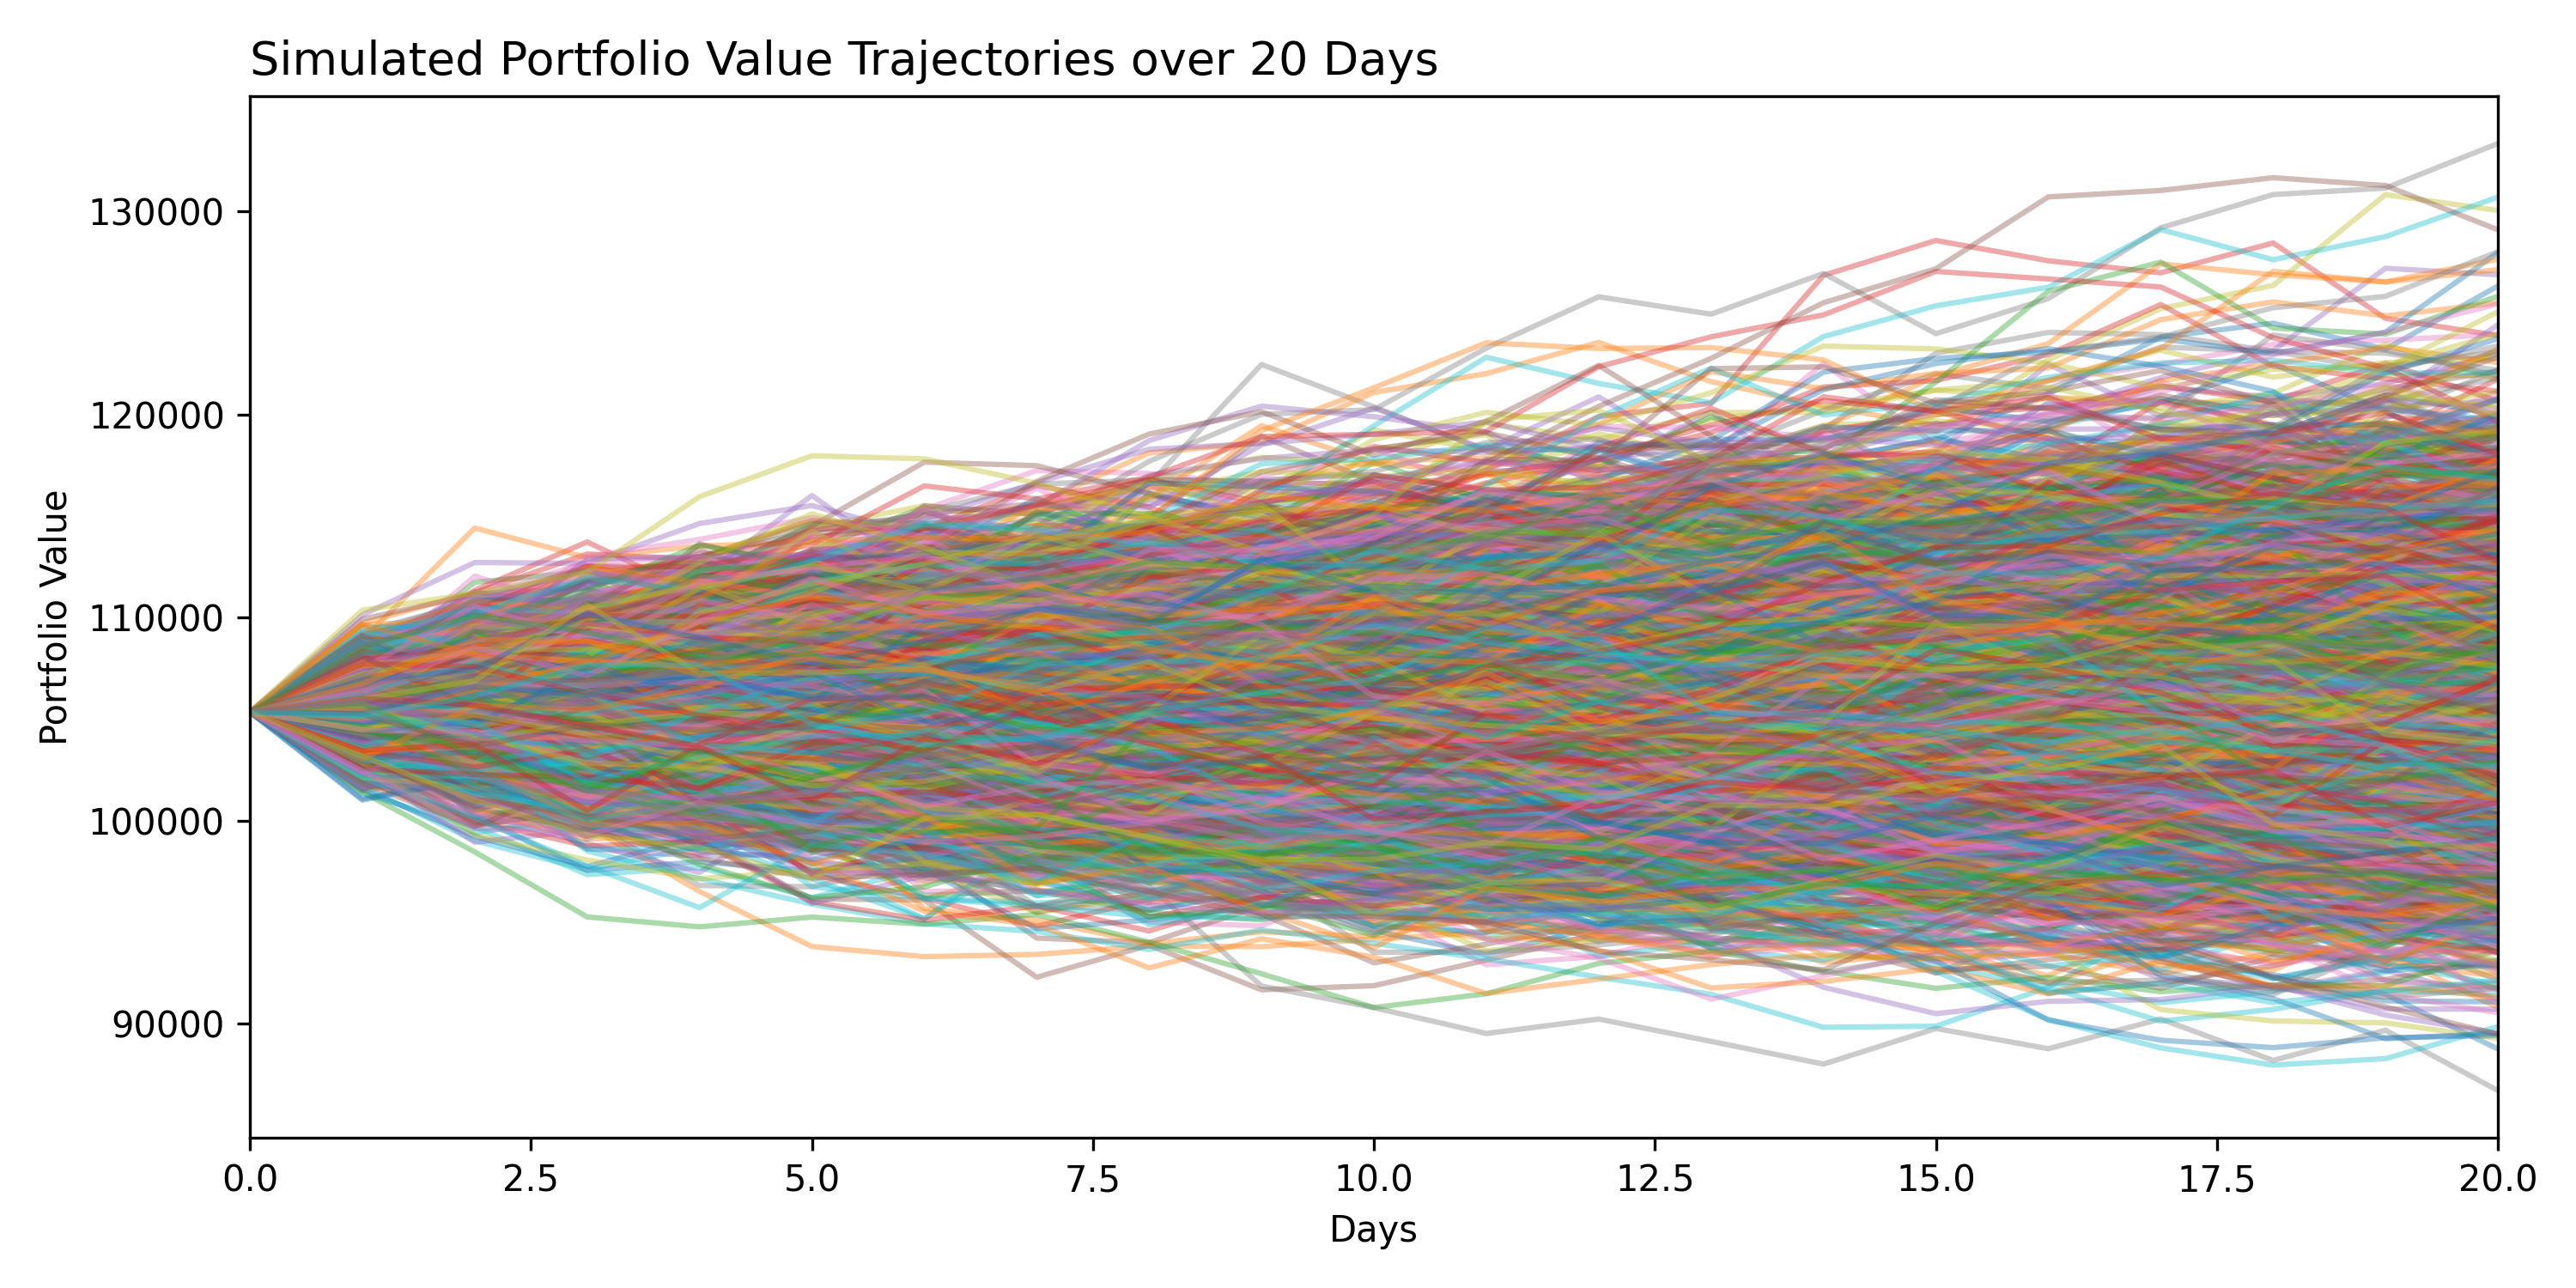

In [47]:
pv.plot_simulated_paths(portfolio_paths)

Historical Simulations, with no replacement.

### Historical Simulation

Historical Simulation (HS) is a non-parametric approach that replays historical shocks to estimate risk.

---

#### Steps:

1. Take a matrix of historical returns:

   $$
   R_{\text{hist}} = \begin{bmatrix}
   r_{1,1} & r_{1,2} & \dots & r_{1,n} \\
   r_{2,1} & r_{2,2} & \dots & r_{2,n} \\
   \vdots  & \vdots  &       & \vdots \\
   r_{T,1} & r_{T,2} & \dots & r_{T,n}
   \end{bmatrix}
   $$

2. For each row $r_t$, simulate prices:

   $$
   S_t^{\text{sim}} = S_0 \cdot (1 + r_t)
   $$

3. Recompute portfolio value $V_t^{\text{sim}}$ under each scenario, including option repricing

4. Compute P&L:

   $$
   \text{P\&L}_t = V_t^{\text{sim}} - V_0
   $$

5. From the empirical distribution of P&L, compute:

   $$
   \text{VaR}_\alpha = - \text{quantile}_\alpha(\text{P\&L})
   $$

   $$
   \text{CVaR}_\alpha = - \mathbb{E}[\text{P\&L} \mid \text{P\&L} \leq \text{quantile}_\alpha(\text{P\&L})]
   $$

---

HS is very intuitive and data-driven, but completely relies on the historical return distribution.



In [48]:
# Run historical simulation (1-day horizon, 99% confidence)
var_hist, pnl_hist = pv.historical_simulation_var(
    price_data=prices_chf,
    shares=shares.values,
    options=options,
    confidence_level=0.99,
)

es_hist = pv.simulation_es(var_hist, pnl_hist)

# Display results
print(f"Historical Simulation VaR (99%):   {var_hist:,.2f} CHF")
print(f"Historical Simulation ES  (99%):   {es_hist:,.2f} CHF")


Historical Simulation VaR (99%):   4,792.48 CHF
Historical Simulation ES  (99%):   7,424.32 CHF



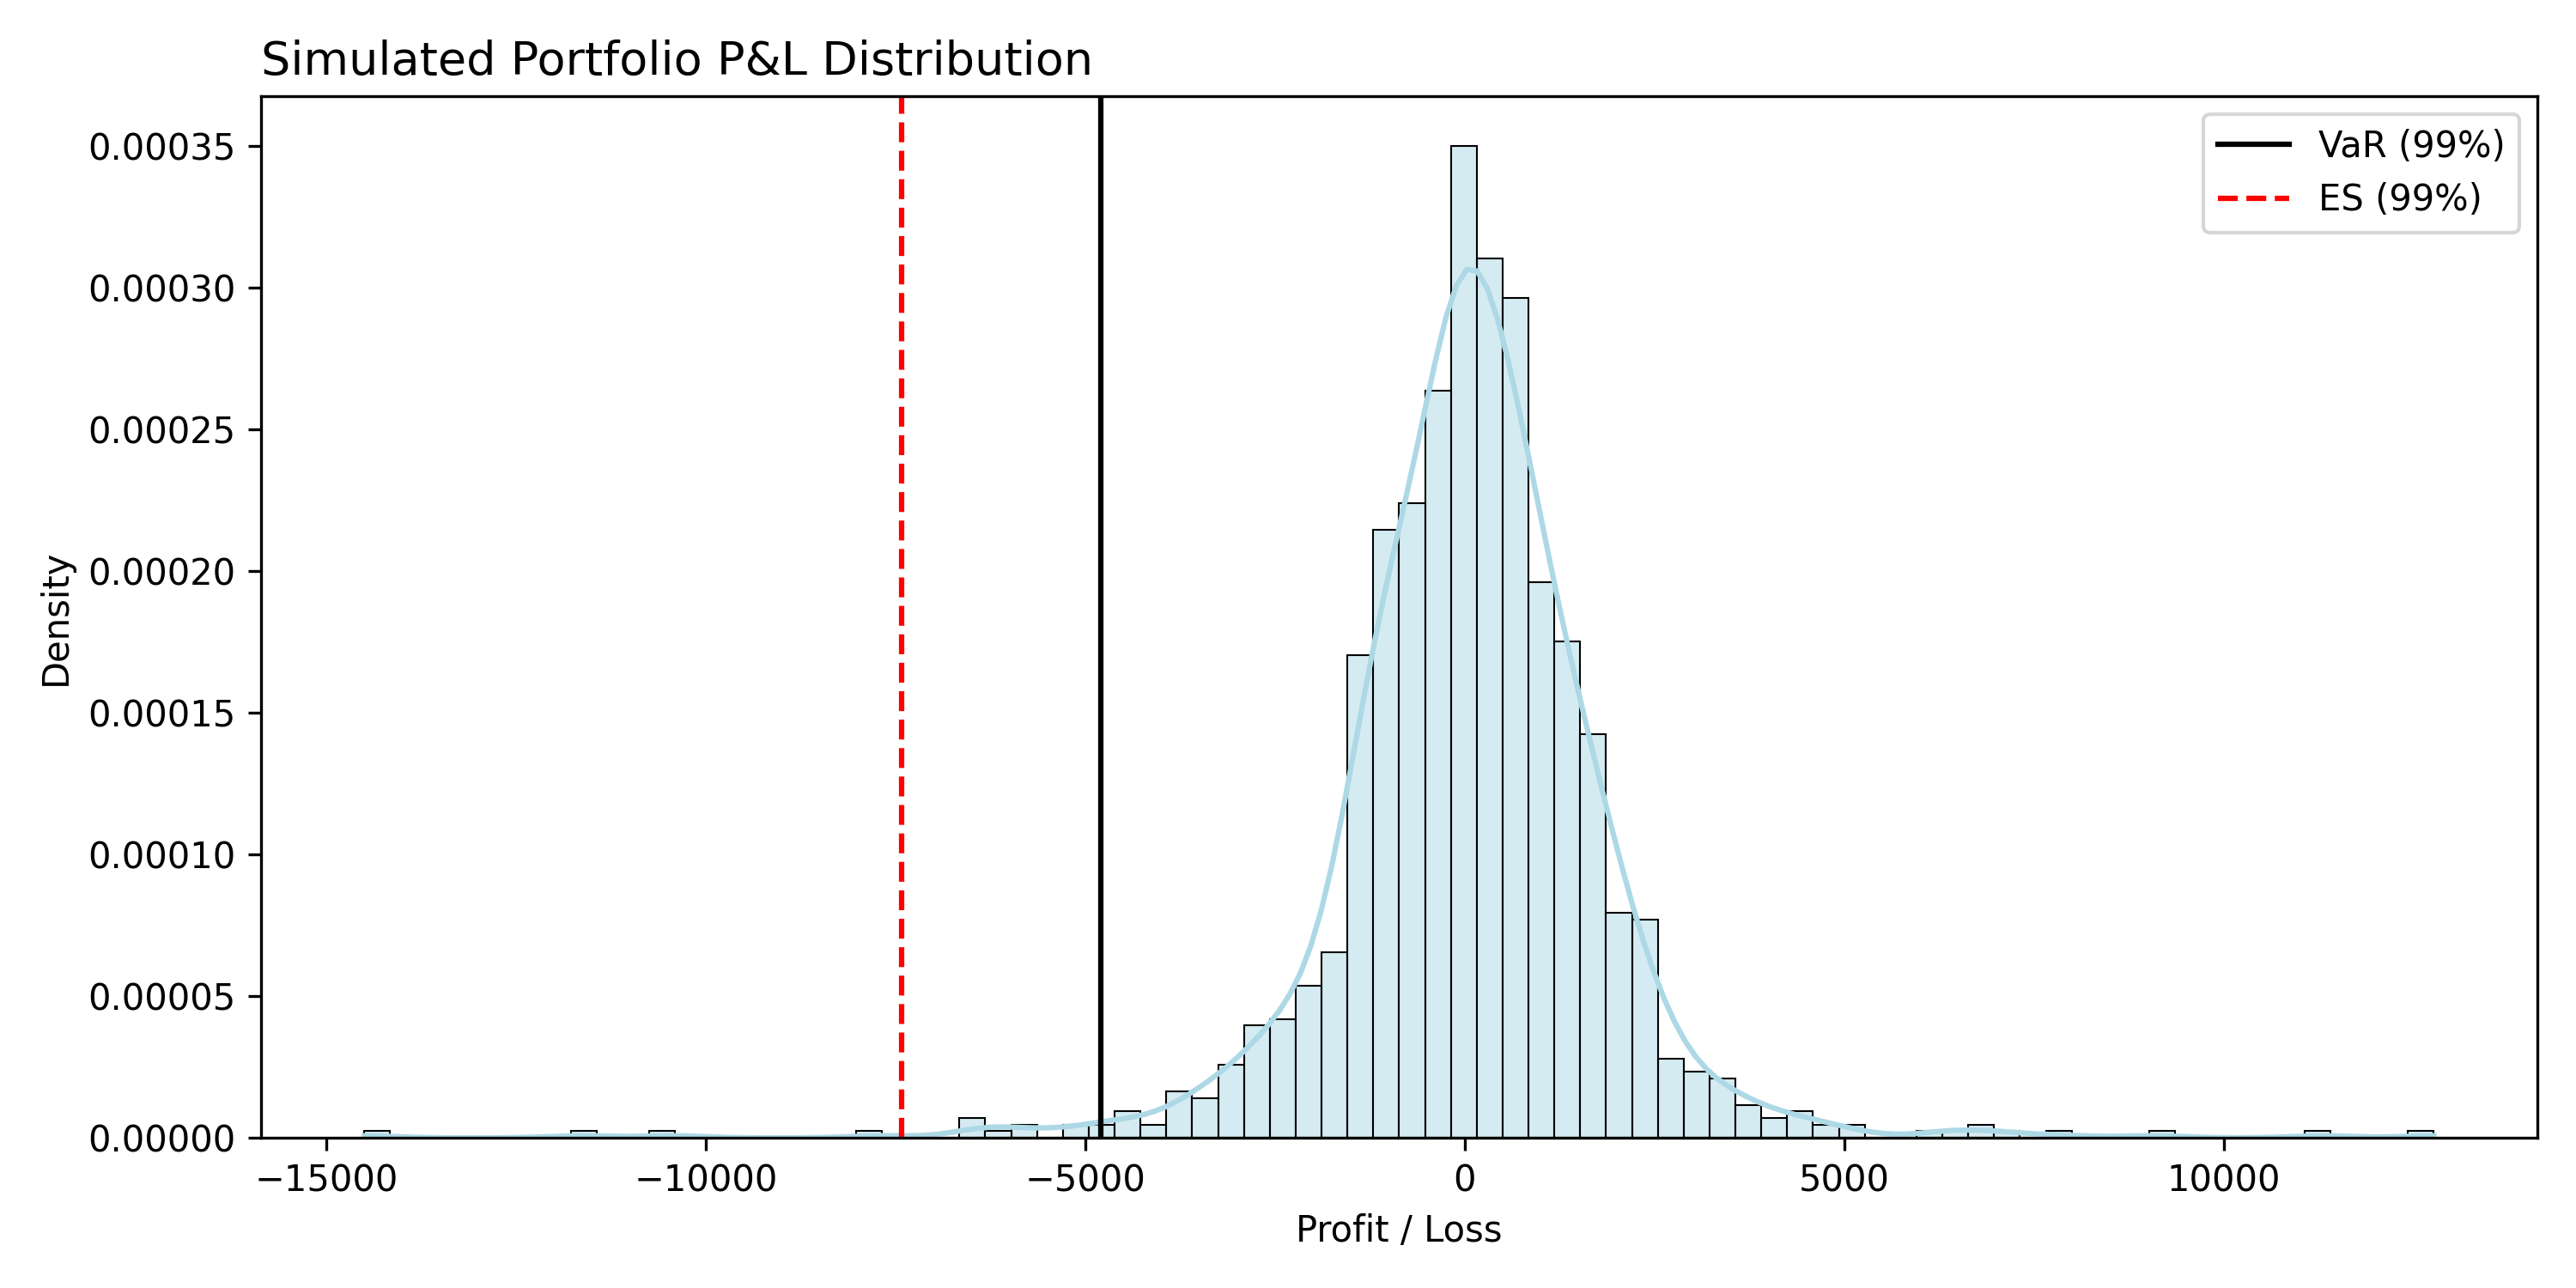

In [49]:
pv.plot_simulated_distribution(
    profit_and_loss=pnl_hist,
    var=var_hist,
    es=es_hist,
    confidence_level=0.99
)

Comparison.

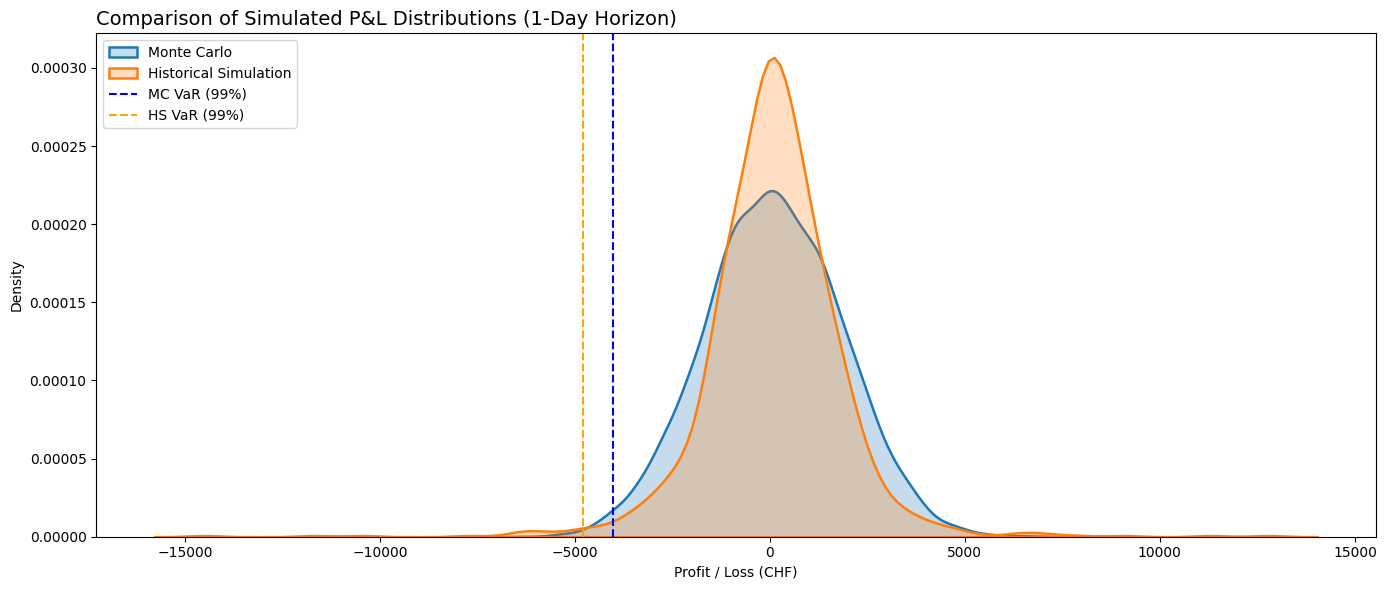

In [50]:
# Larger figure
plt.figure(figsize=(14, 6))

# KDE plots
sns.kdeplot(pnl_mc, label="Monte Carlo", fill=True, color="tab:blue", linewidth=1.8)
sns.kdeplot(pnl_hist, label="Historical Simulation", fill=True, color="tab:orange", linewidth=1.8)

# VaR markers
plt.axvline(-var_mc, color="blue", linestyle="--", linewidth=1.5, label="MC VaR (99%)")
plt.axvline(-var_hist, color="orange", linestyle="--", linewidth=1.5, label="HS VaR (99%)")

# Final formatting
plt.title("Comparison of Simulated P&L Distributions (1-Day Horizon)", fontsize=14, loc="left")
plt.xlabel("Profit / Loss (CHF)")
plt.ylabel("Density")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
